# INSIGHTS

As anotações e documentação dos testes estão no Maxtrade


#### Bibliotecas

In [1]:
# BASIC
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import joblib

# CLASSIFIER
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

#REGRESSOR
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

# PRE-PROCESSING
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

#METRICS
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import log_loss

# STATISTIC
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#INDICATORS
import pandas_ta as ta
from finta import TA
import talib

# DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

# WARNING
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
# APPL HORA EXEMPLO DO ANDRE KUNIYOSHI
colunas = ['Time', 'Open', 'High', 'Low', 'Close','Adj Close','Volume']
df_base = pd.read_csv(r'C:\_PY\Trade_NB\_DS\Bases\df_AAPL_hora.csv')
df_base.columns = colunas
df_base['Time'] = pd.to_datetime(df_base['Time'], utc=True)
df_base.set_index('Time', inplace=True)

df_base = df_base[['Open', 'High', 'Low', 'Close','Adj Close','Volume']]

# conferindo o tamanho do dataset
print('AAPL tamanho:', df_base.shape)

AAPL tamanho: (2273, 6)


### OUTLIERS

### Serie Estacionaria

In [3]:
# Agora, vamos analisar se a série é estacionária, ou não. Para que seja, ela precisa ter a média e a variância constantes no tempo, além de ter correlação entre 2 períodos constante

# Vamos utilizar o teste de Dickey Fuller para verificar se nossa série é estacionária ou não.
# H0 -> Série não estacionária (p-value > 0.05)
# H1 -> Série estacionária (p-value <= 0.05)

# o resultado estatístico mostrou que a série não é estacionária. (p-value > 0.05)
#Então, vamos utilizar a técnica de diferenciação para tornar a série estacionária, para podermos aplicar o modelo ARIMA

adfuller_aapl_hora = adfuller(df_base['Adj Close'])
print('ADF Statistics:', adfuller_aapl_hora[0])
print('p-value :', adfuller_aapl_hora[1])

ADF Statistics: -1.237289366571211
p-value : 0.6573526804673975


In [4]:
# Calculo do retorno percentual (1º diferenciação)
df_arima = df_base.copy()
df_arima['return_percent'] = df_arima['Adj Close'].pct_change()
df_arima.dropna(inplace=True)

In [5]:
# apenas checagem

# rodando o método de Dickey Fuller para retorno PERCENTUAL
adfuller_df_arima = adfuller(df_arima['return_percent'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -8.855398205628859
p-value AAPL HORA: 1.532812259092094e-14


# APLICAÇÃO DO LOG

In [6]:
# TIMEFRAME
#BASE MINUTOS DIARIO 510 
#BASE HORAS POR PREGAO DIARIO: 7
#BASE MESES PREGAO ANO: 12

time_frame = 7

# https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b
df_log = np.log(df_base)
ma_log = df_log.rolling(time_frame).mean()

#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(time_frame).mean()
#desvio padrão
std_sub = df_sub.rolling(time_frame).std()

In [7]:
# apenas checagem

adfuller_df_arima = adfuller(df_log['Adj Close'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -1.1891641156083415
p-value AAPL HORA: 0.6782395798917242


In [8]:
# apenas checagem

#repetir o ADF
X_sub = df_sub['Adj Close'].values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -8.2795
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4333
	5%: -2.8628
	10%: -2.5675


Dickey-Fuller Aumentado
Teste Estatístico: -15.7205
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4333
	5%: -2.8628
	10%: -2.5675


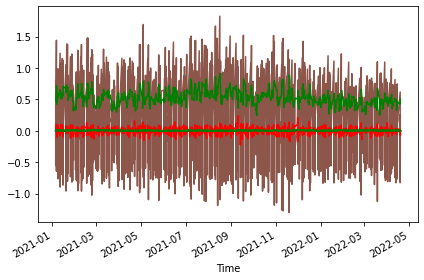

In [9]:
#Diferenciação

#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(time_frame).mean()
#desvio padrão
std_diff = df_diff.rolling(time_frame).std()

#plotar a diferenciação
fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#extrair apenas os valores e retirar os valores NA
X = df_diff['Adj Close'].dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

In [10]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2259 entries, 2021-01-04 20:30:00+00:00 to 2022-04-18 19:30:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2258 non-null   float64
 1   High       2258 non-null   float64
 2   Low        2258 non-null   float64
 3   Close      2258 non-null   float64
 4   Adj Close  2258 non-null   float64
 5   Volume     2258 non-null   float64
dtypes: float64(6)
memory usage: 123.5 KB


In [11]:
df_diff = df_diff.dropna()

In [12]:
df_diff['return_percent'] = df_diff['Adj Close'].pct_change()

### Teste de Normalidade

In [13]:
#Agora, podemos verificar se as distribuições de retorno são normais ou não.

#Para isso, vamos utilizar o método de shapiro, da lib scipy stats
print('Dataset HORAS, retorno PERCENTUAL (1º dif.):', stats.shapiro(df_diff['return_percent']))

Dataset HORAS, retorno PERCENTUAL (1º dif.): ShapiroResult(statistic=nan, pvalue=1.0)


In [14]:
m_df = df_diff.copy()

# FIM DA APLICAÇÃO DO LOG

### Variaveis Vinny

In [15]:
#m_df['amplitude'] = m_df['High'] - m_df['Low']
#m_df['body'] = np.where(m_df["Close"] > m_df["Open"], m_df["Close"] - m_df["Open"], m_df["Open"] - m_df["Close"])
#m_df['pavil'] = m_df['amplitude'] - m_df['body']
#m_df['pavil_call'] = np.where(m_df["Close"] > m_df["Open"], m_df['High'] - m_df['Close'], m_df['High'] - m_df['Open'])
#m_df['pavil_put'] = np.where(m_df["Close"] > m_df["Open"], m_df['Open'] - m_df['Low'], m_df['Close'] - m_df['Low'])
m_df['sma_2'] = m_df.Close.rolling(2).mean()
m_df["force_index"] = m_df["Close"] * m_df["Volume"]
#m_df["retorno_volume"] = m_df["Volume"].pct_change(1)*100
#m_df["retorno"] = m_df["Close"].pct_change(1)*100

#m_df['g_mean'] = m_df["close"].rolling(periodo).apply(lambda x: geometric_mean(x))
#m_df['h_mean'] = m_df["close"].rolling(periodo).apply(lambda x: harmonic_mean(x))
#SOMA
#VWAP

m_df['ema20'] = TA.EMA(m_df, 20)
m_df['ema50'] = TA.EMA(m_df, 50)

m_df['ema9'] = TA.EMA(m_df, 9)
m_df['sma14'] = TA.SMA(m_df, 14)
m_df['sma50'] = TA.SMA(m_df, 50)
m_df['stoch'] = TA.STOCH(m_df)
m_df['ema12'] = TA.EMA(m_df, 12)
m_df['ema26'] = TA.EMA(m_df, 26)
m_df['macd'] = m_df['ema12'] - m_df['ema26']
m_df['macd_signal'] = m_df['macd'].ewm(span=9).mean()
m_df['soma'] = (m_df['Open']-m_df['High'])+(m_df['Open']-m_df['Low'])+(m_df['Open']-m_df['Close'])
m_df['inv_soma'] = np.where(m_df['soma']>0,0,1)

In [16]:
lag_features = ['Open', 'High', 'Low','Close','Volume']
window1=3
window2=7
for feature in lag_features:
    m_df[feature + '_rolling_mean_3'] = m_df[feature].rolling(window=window1).mean()
    m_df[feature + '_rolling_mean_7'] = m_df[feature].rolling(window=window2).mean()

for feature in lag_features:
    m_df[feature + '_rolling_std_3'] = m_df[feature].rolling(window=window1).std()
    m_df[feature + '_rolling_std_7'] = m_df[feature].rolling(window=window2).std()

In [17]:
m_df["VWAP"]=ta.vwap(m_df.High, m_df.Low, m_df.Close, m_df.Volume)
VWAPsignal = [0]*len(m_df)
backcandles = 15

for row in range(backcandles, len(m_df)):
    upt = 1
    dnt = 1
    for i in range(row-backcandles, row+1):
        if max(m_df.Open[i], m_df.Close[i])>=m_df.VWAP[i]:
            dnt=0
        if min(m_df.Open[i], m_df.Close[i])<=m_df.VWAP[i]:
            upt=0
    if upt==1 and dnt==1:
        VWAPsignal[row]=3
    elif upt==1:
        VWAPsignal[row]=2
    elif dnt==1:
        VWAPsignal[row]=1

m_df['VWAPSignal'] = VWAPsignal

In [18]:
#-----------------------------------FEATURE ENGINEERING--------------------------------------------

In [19]:
# CRIANDO FEATURE RSI
def criar_rsi(df):
    n = 20
    def rma(x, n, y0):
        a = (n-1) / n
        ak = a**np.arange(len(x)-1, -1, -1)
        return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

    df['change'] = df['Adj Close'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df['avg_gain'] = rma(df.gain[n+1:].to_numpy(), n, np.nansum(df.gain.to_numpy()[:n+1])/n)
    df['avg_loss'] = rma(df.loss[n+1:].to_numpy(), n, np.nansum(df.loss.to_numpy()[:n+1])/n)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    return df

In [20]:
# CRIANDO FEATURE BOLLINGER BAND
def criar_bollinger(df):
  # calculando a média móvel e limites superior e inferiror
  # limites com base em 2 desvios padrão
  mid = df['Adj Close'].rolling(20).mean()
  std = df['Adj Close'].rolling(20).std()
  up = mid + std
  low = mid - std

  # criando features para a média e os limites
  df['upper'] = up
  df['mid'] = mid
  df['low'] = low
  df['bbp'] = (df['Adj Close'] - df['low'])/(df['upper'] - df['low'])
  df.dropna(inplace=True)
  return df

In [21]:
# RESISTÊNCIA
def is_resistance(df,i):
  resistance = (df['High'][i] > df['High'][i-1]
                and df['High'][i] > df['High'][i+1]
                and df['High'][i+1] > df['High'][i+2]
                and df['High'][i-1] > df['High'][i-2])
  return resistance

# SUPORTE
def is_support(df,i):
  support = (df['Low'][i] < df['Low'][i-1]
             and df['Low'][i] < df['Low'][i+1]
             and df['Low'][i+1] < df['Low'][i+2]
             and df['Low'][i-1] < df['Low'][i-2])
  return support

def suporte_resistencia(df):
  # resistência verdadeiro -> 1 (vender)
  # suporte verdadeiro -> 0 (comprar)
  # outros (2)

  # criando feature com valores 2
  df['suport_resistencia'] = 2

  # definindo os valores 1 e 0
  for i in range(2, df.shape[0] - 2):
    if is_resistance(df,i):
      df['suport_resistencia'][i] = 1 # definindo 1 para resistência
    elif is_support(df,i):
      df['suport_resistencia'][i] = 0 # definindo 0 para suporte
  return df

In [22]:
# LTA E LTB
# 0.5 são classificadas como tendência de alta, menos que -0.5 são tendência de baixa
def lta_ltb(df):
  df2 = df.reset_index()
  df['corr'] = (df2['Adj Close'].rolling(20).corr(pd.Series(df2.index))).tolist()
  df.dropna(inplace=True)

  def condition(x):
      if x<=-0.5:
          return -1
      elif x>-0.5 and x<0.5:
          return 0
      else:
          return 1
  df['corr_class'] = df['corr'].apply(condition)

  return df

In [23]:
# MÉDIA MÓVEL
def media_movel(df, coluna, defasagem):
  df['media_movel'] = df[coluna].rolling(20).mean()
  return df

In [24]:
# FEATURES DE TEMPO
def feat_temporais(df):
  df['dia_semana'] = df.index.dayofweek
  df['horario'] = df.index.hour
  df['mes'] = df.index.month
  return df

In [25]:
# CRIANDO A TARGET
def target(df):

  # criando feature com 1h de defasagem (com hora anterior)
  df['def_1'] = df['Adj Close'].shift(1)
  # criando feature comparando valor atual com o defasado
  df['subt'] = df['Adj Close'] - df['def_1']
#  criando a target de subida ou descida do valor da ação
#  0 -> caiu (com relação ao anterior)
#  1 -> subiu (com relação ao anterior)
#  2 -> igual ao anterior
  
  #df['target'] = df['subt'].apply(lambda x: int(0) if x<0 else int(1) if x>0 else int(2))
  df['target'] = df['subt'].apply(lambda x: int(0) if x<=0 else int(1))
  return df


In [26]:
# FEATURES DEFASADAS 
def constroi_features_defasadas(df,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    df_cop = df.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            df_cop[str(feat)+'_def_'+str(i)] = df_cop[feat].shift(i)
    
    df_cop.dropna(inplace=True)
    return df_cop

In [27]:
# FEATURES FUTURAS
def constroi_features_futuras(df,feature,defasagem):
    # Constrói features defasadas com base na base original
    # Copia a base
    df_cop = df.copy()

    df_cop[str(feature)+'_fut'] = df_cop[feature].shift(-defasagem)
    return df_cop

In [28]:
m_df = criar_rsi(m_df) # 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi'
m_df = criar_bollinger(m_df) #'upper', 'mid', 'low','bbp'
m_df = suporte_resistencia(m_df) #'suport_resistencia'
m_df = lta_ltb(m_df) # 'corr', 'corr_class'
m_df = media_movel(m_df, 'Adj Close', 20) # 'media_movel'
m_df = feat_temporais(m_df) # 'dia_semana', 'horario', 'mes'

In [29]:
###-----------------------------------FUNÇÃO DO MODELO-------------------------------------------- '''

In [30]:
def modelo(df, target_):
    X_test = df.drop(target_, axis=1)[-1:]

    X_train = df[:-1].dropna().drop(target_, axis=1)
    y_train = df[:-1].dropna()[target_]

    xgb = XGBClassifier(random_state=42,
			gamma = 0.1,
			max_depth = 8,
			n_estimators = 100,
			n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    return y_pred, y_proba

In [31]:
def preprocessamento(base, corte_treino_teste,target):
  # separando a base da target
  X = base.drop(target, axis=1)
  y = base[target]
  # cortando em treino e teste
  X_train = X[X.index<=corte_treino_teste]
  X_test = X[X.index>corte_treino_teste]
  y_train = y[y.index<=corte_treino_teste]
  y_test = y[y.index>corte_treino_teste]
  return X_train, X_test, y_train, y_test

In [32]:
modelos_candidatos = {'Árvore':DecisionTreeClassifier(random_state=42),
                      'RandomForest':RandomForestClassifier(random_state=42),
                      'XGBoost':XGBClassifier(random_state=42)
                     }
def avaliacao_modelos(modelos,X_train,y_train):
  avaliacao = {}
  scores = []
  ts = TimeSeriesSplit(n_splits=5).split(X_train,y_train)
  for nome,model in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                          X_train, y_train, # Nossos dados, excluindo o teste
                          cv=TimeSeriesSplit(n_splits=5).split(X_train,y_train), # Validação cruzada temporal
                          scoring='accuracy', # Usando a acurácia como métrica
                          ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = score
    scores.append(score)
  
  return avaliacao, scores

In [33]:
m_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'return_percent',
       'sma_2', 'force_index', 'ema20', 'ema50', 'ema9', 'sma14', 'sma50',
       'stoch', 'ema12', 'ema26', 'macd', 'macd_signal', 'soma', 'inv_soma',
       'Open_rolling_mean_3', 'Open_rolling_mean_7', 'High_rolling_mean_3',
       'High_rolling_mean_7', 'Low_rolling_mean_3', 'Low_rolling_mean_7',
       'Close_rolling_mean_3', 'Close_rolling_mean_7', 'Volume_rolling_mean_3',
       'Volume_rolling_mean_7', 'Open_rolling_std_3', 'Open_rolling_std_7',
       'High_rolling_std_3', 'High_rolling_std_7', 'Low_rolling_std_3',
       'Low_rolling_std_7', 'Close_rolling_std_3', 'Close_rolling_std_7',
       'Volume_rolling_std_3', 'Volume_rolling_std_7', 'VWAP', 'VWAPSignal',
       'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi', 'upper',
       'mid', 'low', 'bbp', 'suport_resistencia', 'corr', 'corr_class',
       'media_movel', 'dia_semana', 'horario', 'mes'],
      dtype='object')

In [34]:
##-----------------------------------CRIANDO DATASET-------------------------------------------- '''
hora_previsao = 1
m_df = target(m_df)
m_df.dropna(inplace=True) #, 'bbp', 'corr_class'
#m_df = m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]

#vinny
#m_df = m_df[['bbp', 'corr_class','target', 'Adj Close', 'Volume','amplitude', 'body','VWAP', 'VWAPSignal', 'pavil', 'pavil_call', 'pavil_put', 'sma_2','force_index','rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]

#vinny2
m_df = m_df[['Adj Close', 'Volume','rsi','bbp', 'suport_resistencia','corr_class',
        'target','media_movel', 'dia_semana', 'horario', 'mes',
       'sma_2', 'force_index', 'ema20', 'ema50', 'ema9', 'sma14', 'sma50',
       'stoch', 'ema12', 'ema26', 'macd', 'macd_signal', 'soma', 'inv_soma',
       'Open_rolling_mean_3', 'Open_rolling_mean_7', 'High_rolling_mean_3',
       'High_rolling_mean_7', 'Low_rolling_mean_3', 'Low_rolling_mean_7',
       'Close_rolling_mean_3', 'Close_rolling_mean_7', 'Volume_rolling_mean_3',
       'Volume_rolling_mean_7', 'Open_rolling_std_3', 'Open_rolling_std_7',
       'High_rolling_std_3', 'High_rolling_std_7', 'Low_rolling_std_3',
       'Low_rolling_std_7', 'Close_rolling_std_3', 'Close_rolling_std_7',
       'Volume_rolling_std_3', 'Volume_rolling_std_7', 'VWAP', 'VWAPSignal']]

#Andre
#m_df = m_df[['bbp', 'corr_class','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = constroi_features_defasadas(m_df,['Adj Close'],20)
m_df = constroi_features_futuras(m_df,'target',hora_previsao)
m_df = m_df.drop('target', axis=1)

### Normalização

In [35]:
#scaler = MinMaxScaler()#StandardScaler() #MinMaxScaler() MaxAbsScaler()
scaler = MinMaxScaler()#() #MaxAbsScaler()

### Treino Teste

In [36]:
m_df = m_df.dropna()

##### exemplo do Andre

In [38]:
# VINNY 2 #'target' removi devido a msg de erro not index
m_df = m_df.loc[:,['Adj Close', 'Volume','rsi','bbp', 'suport_resistencia','corr_class',
        'media_movel', 'dia_semana', 'horario', 'mes',
       'sma_2', 'force_index', 'ema20', 'ema50', 'ema9', 'sma14', 'sma50',
       'stoch', 'ema12', 'ema26', 'macd', 'macd_signal', 'soma', 'inv_soma',
       'Open_rolling_mean_3', 'Open_rolling_mean_7', 'High_rolling_mean_3',
       'High_rolling_mean_7', 'Low_rolling_mean_3', 'Low_rolling_mean_7',
       'Close_rolling_mean_3', 'Close_rolling_mean_7', 'Volume_rolling_mean_3',
       'Volume_rolling_mean_7', 'Open_rolling_std_3', 'Open_rolling_std_7',
       'High_rolling_std_3', 'High_rolling_std_7', 'Low_rolling_std_3',
       'Low_rolling_std_7', 'Close_rolling_std_3', 'Close_rolling_std_7',
       'Volume_rolling_std_3', 'Volume_rolling_std_7', 'VWAP', 'VWAPSignal',
        'Adj Close_def_1', 'Adj Close_def_2',
       'Adj Close_def_3', 'Adj Close_def_4', 'Adj Close_def_5',
       'Adj Close_def_6', 'Adj Close_def_7', 'Adj Close_def_8',
       'Adj Close_def_9', 'Adj Close_def_10', 'Adj Close_def_11',
       'Adj Close_def_12', 'Adj Close_def_13', 'Adj Close_def_14',
       'Adj Close_def_15', 'Adj Close_def_16', 'Adj Close_def_17',
       'Adj Close_def_18', 'Adj Close_def_19', 'Adj Close_def_20','target_fut']]

# REGRESSAO

In [39]:
rx_train, rx_test, ry_train, ry_test = preprocessamento(m_df.iloc[:,:-1], m_df.index[round(len(m_df.index) * 0.8)], 'Adj Close')
rx_train = scaler.fit_transform(rx_train)
rx_test  = scaler.transform(rx_test)

In [40]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(rx_train, ry_train)
pred= lr.predict(rx_test)
cd =r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd * 100:.2f}'


'Coeficiente de determinação (R2):100.00'

In [41]:
# instanciando o modelo Support Vector Regression
svr = SVR()

# treinando o modelo
svr.fit(rx_train, ry_train)

# prevendo os valores
y_predict = svr.predict(rx_test)
cd_svr = r2_score(ry_test, y_predict)

f'Coeficiente de determinação (R2):{cd_svr * 100:.2f}'


'Coeficiente de determinação (R2):-31.26'

In [42]:
# instanciando o modelo Random Forest Regressor
rfr = RandomForestRegressor(n_estimators= 20, random_state=42).fit(rx_train, ry_train); #n_estimators= 10, random_state=42
pred = rfr.predict(rx_test)
cd_RL = r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd_RL * 100:.2f}'


'Coeficiente de determinação (R2):95.48'

In [43]:
# instanciando o modelo XGBoost Regressor


xgbr = XGBRegressor()
xgbr.fit(rx_train, ry_train)
pred = xgbr.predict(rx_test)

cd_XGBR = r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd_XGBR * 100:.2f}'


'Coeficiente de determinação (R2):95.96'

In [44]:
#rede neural
rn = MLPRegressor(max_iter=2000)

rn.fit(rx_train, ry_train)
pred = rn.predict(rx_test)

cd = rn.score(rx_test, ry_test)


f'Coeficiente de determinação:{cd * 100:.2f}'

'Coeficiente de determinação:-2581.63'

In [ ]:
#rx_train, rx_test, ry_train, ry_test

### ENSEMBLE REGRESSOR

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [46]:
X_scaled = (rx_train)
X_scaled_test = (rx_test)

In [47]:
# Training regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 =  XGBRegressor(random_state=1) #LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('xbr', reg3)])
ereg = ereg.fit(rx_train, ry_train)

In [48]:
predict1 = pd.DataFrame(ry_train)
for model in (reg1, reg2, reg3, ereg):
  model.fit(X_scaled, ry_train)
  ry_pred = model.predict(X_scaled)
  predict1[model.__class__.__name__] = ry_pred

In [49]:
predict2 = pd.DataFrame(ry_test)
for model in (reg1, reg2, reg3, ereg):
  model.fit(X_scaled, ry_train)
  ry_pred = model.predict(X_scaled_test)
  predict2[model.__class__.__name__] = ry_pred

In [50]:
# obtendo as métricas R2
model = []
r2 = []
for clf in (reg1, reg2, reg3, ereg):
  clf.fit(X_scaled, ry_train)
  ry_pred = clf.predict(X_scaled_test)
  model.append(clf.__class__.__name__)
  r2.append(r2_score(ry_test, ry_pred))

col = ['R2']
ac = pd.DataFrame(data=r2, index = model,columns=col)
ac

R2
GradientBoostingRegressor  0.967151
RandomForestRegressor      0.962280
XGBRegressor               0.959624
VotingRegressor            0.968326

<AxesSubplot:xlabel='Time'>

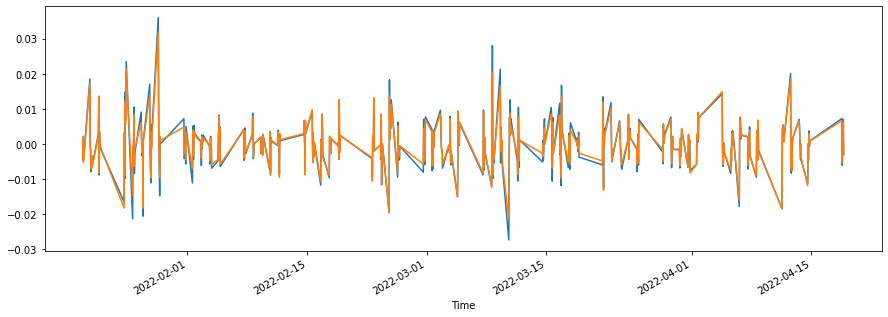

In [51]:
plt.figure(figsize=(15,5))
predict2['Adj Close'].plot()
predict2['VotingRegressor'].plot()

In [52]:
predict_regressor = predict1.append(predict2)

In [53]:
predict_regressor

Adj Close  GradientBoostingRegressor  \
Time                                                              
2021-01-27 16:30:00+00:00   0.004331                   0.003784   
2021-01-27 17:30:00+00:00  -0.001118                  -0.000751   
2021-01-27 18:30:00+00:00  -0.002406                  -0.001828   
2021-01-27 19:30:00+00:00  -0.007430                  -0.006904   
2021-01-27 20:30:00+00:00   0.006597                   0.005637   
...                              ...                        ...   
2022-04-18 14:30:00+00:00  -0.006083                  -0.006227   
2022-04-18 15:30:00+00:00  -0.002585                  -0.002166   
2022-04-18 16:30:00+00:00   0.006372                   0.005371   
2022-04-18 17:30:00+00:00   0.006881                   0.006149   
2022-04-18 18:30:00+00:00  -0.003033                  -0.002905   

                           RandomForestRegressor  XGBRegressor  \
Time                                                             
2021-01-27 16:30:00+00:00               0.003719      0.003872   
2021-01-27 17:30:00+00:00              -0.000996     -0.000924   
2021-01-27 18:30:00+00:00              -0.002185     -0.001772   
2021-01-27 19:30:00+00:00              -0.006857     -0.007118   
2021-01-27 20:30:00+00:00               0.006272      0.006345   
...                                          ...           ...   
2022-04-18 14:30:00+00:00              -0.005806     -0.003826   
2022-04-18 15:30:00+00:00              -0.003067     -0.002589   
2022-04-18 16:30:00+00:00               0.005874      0.005935   
2022-04-18 17:30:00+00:00               0.006982      0.005439   
2022-04-18 18:30:00+00:00              -0.003051     -0.002615   

                           VotingRegressor  
Time                                        
2021-01-27 16:30:00+00:00         0.003792  
2021-01-27 17:30:00+00:00        -0.000891  
2021-01-27 18:30:00+00:00        -0.001928  
2021-01-27 19:30:00+00:00        -0.006960  
2021-01-27 20:30:00+00:00         0.006085  
...                                    ...  
2022-04-18 14:30:00+00:00        -0.005286  
2022-04-18 15:30:00+00:00        -0.002607  
2022-04-18 16:30:00+00:00         0.005726  
2022-04-18 17:30:00+00:00         0.006190  
2022-04-18 18:30:00+00:00        -0.002857  

[2150 rows x 5 columns]

# CLASSIFIER

In [54]:
m_df['VotingRegressor'] = predict_regressor['VotingRegressor']

##### TRAIN TEST SPLIT 80%

##### TIME SERIES SPLIT

In [39]:
tss = TimeSeriesSplit(n_splits = 5)
X = m_df.drop(labels=['target_fut'], axis=1)
y = m_df['target_fut']

for train_index, test_index in tss.split(X):
    x_train, x_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
#Y_train.groupby('Time').mean().plot()
#Y_test.groupby('Time').mean().plot()
    
#x_train, x_test, y_train, y_test = preprocessamento(m_df, m_df.index[round(len(m_df.index) * 0.8)], 'target_fut')

x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [40]:
len(x_test), len(x_train)

(358, 1792)

##### MODELOS CANDIDATOS - ANDRÉ

In [41]:
avaliacao_modelos(modelos_candidatos, x_train, y_train)

({'Árvore': 0.6590604026845638,
  'RandomForest': 0.7503355704697986,
  'XGBoost': 0.7402684563758389},
 [0.6590604026845638, 0.7503355704697986, 0.7402684563758389])

#### Testando o modelo campeao

              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74       219
         1.0       0.73      0.72      0.73       210

    accuracy                           0.74       429
   macro avg       0.74      0.74      0.74       429
weighted avg       0.74      0.74      0.74       429



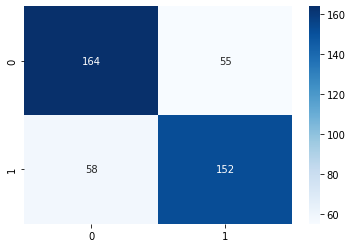

In [42]:
# BUGADO - Input cotains NaNs

base_cop = m_df.dropna().copy()
base_cop = constroi_features_futuras(base_cop,'target_fut',1)
base_cop.drop(['target_fut_fut'], axis=1, inplace=True)
X1_train, X1_test, y1_train, y1_test = preprocessamento(base_cop, base_cop.index[round(len(base_cop.index) * 0.8)], 'target_fut')
# criando df de resultados
result = pd.DataFrame()
# fitando o modelo
xgb = XGBClassifier(random_state=42,max_depth=5, gamma=0.75, n_estimators = 50)
xgb.fit(X1_train, y1_train)
y1_pred = xgb.predict(X1_test)
y1_proba = xgb.predict_proba(X1_test)
y1_proba = y1_proba[:, 1]
# criando as colunas de resultados
result['y1_test'] = y1_test
result['y1_predict'] = y1_pred
result['proba'] = y1_proba

print(metrics.classification_report(y1_test, y1_pred))

# criando a matriz de confusão
ax = sns.heatmap(metrics.confusion_matrix(y1_test, y1_pred),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')


#### Importância das features

Text(0.5, 1.0, 'Feature Importance')

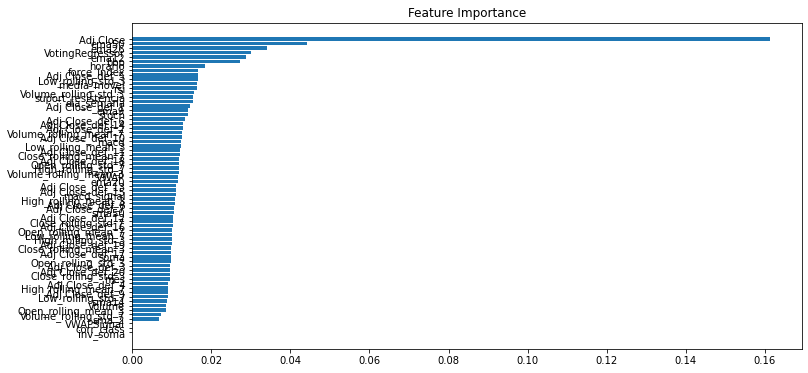

In [102]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X1_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### Selecionando as melhores features com KBest

In [103]:
#separando as features e labels
features = m_df.drop(['target_fut'], 1)
labels = m_df['target_fut']

In [104]:
features.shape

(2150, 67)

In [105]:
features.columns

Index(['Adj Close', 'Volume', 'rsi', 'bbp', 'suport_resistencia', 'corr_class',
       'media_movel', 'dia_semana', 'horario', 'mes', 'sma_2', 'force_index',
       'ema20', 'ema50', 'ema9', 'sma14', 'sma50', 'stoch', 'ema12', 'ema26',
       'macd', 'macd_signal', 'soma', 'inv_soma', 'Open_rolling_mean_3',
       'Open_rolling_mean_7', 'High_rolling_mean_3', 'High_rolling_mean_7',
       'Low_rolling_mean_3', 'Low_rolling_mean_7', 'Close_rolling_mean_3',
       'Close_rolling_mean_7', 'Volume_rolling_mean_3',
       'Volume_rolling_mean_7', 'Open_rolling_std_3', 'Open_rolling_std_7',
       'High_rolling_std_3', 'High_rolling_std_7', 'Low_rolling_std_3',
       'Low_rolling_std_7', 'Close_rolling_std_3', 'Close_rolling_std_7',
       'Volume_rolling_std_3', 'Volume_rolling_std_7', 'VWAP', 'VWAPSignal',
       'Adj Close_def_1', 'Adj Close_def_2', 'Adj Close_def_3',
       'Adj Close_def_4', 'Adj Close_def_5', 'Adj Close_def_6',
       'Adj Close_def_7', 'Adj Close_def_8', 'Adj Close_d

In [114]:
features_list = ('Adj Close', 'Volume', 'rsi', 'bbp', 'suport_resistencia', 'corr_class',
       'media_movel', 'dia_semana', 'horario', 'mes', 'sma_2', 'force_index',
       'ema20', 'ema50', 'ema9', 'sma14', 'sma50', 'stoch', 'ema12', 'ema26',
       'macd', 'macd_signal', 'soma', 'inv_soma', 'Open_rolling_mean_3',
       'Open_rolling_mean_7', 'High_rolling_mean_3', 'High_rolling_mean_7',
       'Low_rolling_mean_3', 'Low_rolling_mean_7', 'Close_rolling_mean_3',
       'Close_rolling_mean_7', 'Volume_rolling_mean_3',
       'Volume_rolling_mean_7', 'Open_rolling_std_3', 'Open_rolling_std_7',
       'High_rolling_std_3', 'High_rolling_std_7', 'Low_rolling_std_3',
       'Low_rolling_std_7', 'Close_rolling_std_3', 'Close_rolling_std_7',
       'Volume_rolling_std_3', 'Volume_rolling_std_7', 'VWAP', 'VWAPSignal',
       'Adj Close_def_1', 'Adj Close_def_2', 'Adj Close_def_3',
       'Adj Close_def_4', 'Adj Close_def_5', 'Adj Close_def_6',
       'Adj Close_def_7', 'Adj Close_def_8', 'Adj Close_def_9',
       'Adj Close_def_10', 'Adj Close_def_11', 'Adj Close_def_12',
       'Adj Close_def_13', 'Adj Close_def_14', 'Adj Close_def_15',
       'Adj Close_def_16', 'Adj Close_def_17', 'Adj Close_def_18',
       'Adj Close_def_19', 'Adj Close_def_20', 'VotingRegressor')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:67])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
#print (k_best_features_final)
for i in k_best_features_final:
    print(i)


Melhores features:
Adj Close_def_7
VotingRegressor
Adj Close_def_3
Adj Close_def_6
Adj Close_def_1
suport_resistencia
bbp
Volume
sma14
ema26
macd_signal
ema12
ema50
macd
ema9
force_index
Close_rolling_mean_7
inv_soma
Open_rolling_mean_3
Volume_rolling_mean_3
stoch
sma50
dia_semana
High_rolling_mean_7
Low_rolling_mean_7
ema20
soma
Low_rolling_mean_3
Close_rolling_mean_3
corr_class
High_rolling_std_7
Open_rolling_mean_7
media_movel
Low_rolling_std_7
Adj Close_def_16
Adj Close_def_17
High_rolling_mean_3
rsi
Low_rolling_std_3
Close_rolling_std_3
Adj Close_def_20
Adj Close_def_19
mes
Volume_rolling_mean_7
sma_2
Adj Close_def_8
Open_rolling_std_7
Adj Close_def_2
Adj Close_def_15
VWAPSignal
Adj Close_def_9
Volume_rolling_std_7
Close_rolling_std_7
Adj Close_def_18
Volume_rolling_std_3
Adj Close_def_13
Adj Close_def_10
High_rolling_std_3
Open_rolling_std_3
Adj Close_def_5
horario
Adj Close_def_14
Adj Close_def_12
Adj Close_def_4
Adj Close_def_11
VWAP


## Otimização de Hiperparâmetros

### GRID SEARCH

In [ ]:
X_train, X_test, y_train, y_test = preprocessamento(base_cop, base_cop.index[round(len(base_cop.index) * 0.8)], 'target_fut')
# otimização para XGBoost undersampled
xgb = XGBClassifier(random_state=42)
parametros_xgb = {
    'n_estimators': range(50,250,50),
    'max_depth': range(2,10,1),
    'gamma':[0.1, 0.5, 0.75]}
    
# Obtendo melhores parâmetros e melhor recall para XGBoosty
grid_xgb = GridSearchCV(estimator = xgb,
                        param_grid = parametros_xgb,
                        cv=5,
                        scoring = 'f1_weighted')
grid_xgb.fit(X_train[-600:], y_train[-600:]) # somente a melhor qtd encontrada
#grid_xgb.fit(X_train, y_train) # pra tudo
xgb_over_best_params = grid_xgb.best_params_
xgb_over_best_score = grid_xgb.best_score_
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

#{'gamma': 0.75, 'max_depth': 5, 'n_estimators': 50} 0.7945981914773684 # using [-600:]
#{'gamma': 0.1, 'max_depth': 2, 'n_estimators': 50} 0.7671352650732206 # using ALL
#{'gamma': 0.1, 'max_depth': 4, 'n_estimators': 100} 0.7482321169545265 # using [-200:]

### PARAMETROS:

In [ ]:
space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

### RANDOM SEARCH

In [ ]:
# pip install scikit-optimize
from skopt import dummy_minimize

In [ ]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100)
    mdl.fit(x_train, y_train)
    
    p = mdl.predict_proba(x_test)[:,1]
    
    return -roc_auc_score(y_test, p)

resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)

In [ ]:
resultado.x

In [ ]:
resultado.fun

In [ ]:
from skopt.plots import plot_convergence

In [ ]:
plot_convergence(resultado, resultados_gp)

### BAYESIAN OPTIMIZATION

In [ ]:
from skopt import gp_minimize

In [ ]:
resultados_gp = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

In [ ]:
resultados_gp.x

In [ ]:
resultados_gp.fun

In [ ]:
from skopt.plots import plot_convergence

In [ ]:
plot_convergence(resultado, resultados_gp)

### MEUS MODELOS

####  RN - LSTM

In [44]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(2, input_shape=(x_train.shape[1], 1)))
LSTM_model.add(Dense(1, activation="sigmoid"))
LSTM_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) #metrics=["acc"]
LSTM_model.fit(x_train[:, :, np.newaxis], y_train, epochs=100)
LSTM_y_pred = LSTM_model.predict(x_test[:, :, np.newaxis])
print(accuracy_score(y_test, LSTM_y_pred > 0.5))
#LSTM_cd = LSTM_model.score(rx_test, ry_test)
#f'Coeficiente de determinação:{LSTM_cd * 100:.2f}'
#LSTM_model.

Epoch 1/100
56/56 [==============================] - 3s 23ms/step - loss: 0.7000 - accuracy: 0.4933
Epoch 2/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6951 - accuracy: 0.4933
Epoch 3/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6939 - accuracy: 0.4933
Epoch 4/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6934 - accuracy: 0.4855
Epoch 5/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6933 - accuracy: 0.5045
Epoch 6/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6934 - accuracy: 0.4922
Epoch 7/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 8/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6933 - accuracy: 0.5045
Epoch 9/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.5050
Epoch 10/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6932 - accuracy: 0.5033

56/56 [==============================] - 1s 22ms/step - loss: 0.6931 - accuracy: 0.5061
Epoch 82/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 83/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 84/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 85/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 86/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.4983
Epoch 87/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 88/100
56/56 [==============================] - 1s 22ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 89/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6931 - accuracy: 0.5067
Epoch 90/100
56/56 [==============================] - 1s 23ms/step - loss: 0.6931 - accuracy: 0.5067
Epo

In [45]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


#### LSTM ISRAELENSE - PERSONALIZADA

In [51]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [61]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(240, input_shape=(x_train.shape[1], 1))) #LSTM_model.add(LSTM(2, input_shape=(x_train.shape[1], 1)))
LSTM_model.add(Dense(1, activation="sigmoid"))
LSTM_model.compile(optimizer=Adam(learning_rate=0.0001),  loss="binary_crossentropy", metrics=["accuracy"]) #metrics=["acc"]
LSTM_model.fit(x_train[:, :, np.newaxis], y_train, batch_size=100, epochs=100, verbose=2)
LSTM_y_pred = LSTM_model.predict(x_test[:, :, np.newaxis])
print(accuracy_score(y_test, LSTM_y_pred > 0.5))

Epoch 1/100
18/18 - 9s - loss: 0.6932 - accuracy: 0.5067
Epoch 2/100
18/18 - 7s - loss: 0.6931 - accuracy: 0.5067
Epoch 3/100
18/18 - 7s - loss: 0.6931 - accuracy: 0.5067
Epoch 4/100
18/18 - 7s - loss: 0.6932 - accuracy: 0.5067
Epoch 5/100
18/18 - 7s - loss: 0.6930 - accuracy: 0.5067
Epoch 6/100
18/18 - 7s - loss: 0.6931 - accuracy: 0.5067
Epoch 7/100
18/18 - 7s - loss: 0.6931 - accuracy: 0.5067
Epoch 8/100
18/18 - 7s - loss: 0.6931 - accuracy: 0.5067
Epoch 9/100
18/18 - 7s - loss: 0.6930 - accuracy: 0.5067
Epoch 10/100
18/18 - 7s - loss: 0.6930 - accuracy: 0.5067
Epoch 11/100
18/18 - 7s - loss: 0.6929 - accuracy: 0.5067
Epoch 12/100
18/18 - 7s - loss: 0.6922 - accuracy: 0.5067
Epoch 13/100
18/18 - 7s - loss: 0.6835 - accuracy: 0.5301
Epoch 14/100
18/18 - 7s - loss: 0.6822 - accuracy: 0.5190
Epoch 15/100
18/18 - 7s - loss: 0.6448 - accuracy: 0.6384
Epoch 16/100
18/18 - 7s - loss: 0.6322 - accuracy: 0.6602
Epoch 17/100
18/18 - 7s - loss: 0.6372 - accuracy: 0.6635
Epoch 18/100
18/18 - 7s

In [66]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
batch_size = 100

# Initialising the RNN
LSTM_model = Sequential()
# Adding the input layer and the LSTM layer
LSTM_model.add(Bidirectional(LSTM(240,
                        input_shape = (x_train.shape[1], 1),
                        return_sequences = True)))
# Adding a first Dropout layer
LSTM_model.add(Dropout(0.2))
# Adding a second LSTM layer
LSTM_model.add(Bidirectional(LSTM(240,
                        input_shape = (x_train.shape[1], 1),
                        return_sequences = True)))
# Adding a second Dropout layer
LSTM_model.add(Dropout(0.2))
# Adding a third LSTM layer
LSTM_model.add(Bidirectional(LSTM(240,
                        input_shape = (x_train.shape[1], 1),
                        return_sequences = True)))
# Adding a fourth LSTM layer
LSTM_model.add(Bidirectional(LSTM(240,
                        input_shape = (x_train.shape[1], 1),
                        return_sequences = False)))
# Adding a fourth Dropout layer
LSTM_model.add(Dropout(0.2))
# Adding the first output layer
LSTM_model.add(Dense(x_train.shape[1])) #59
# Adding the last output layer
LSTM_model.add(Dense(x_train.shape[1]))

In [67]:
LSTM_model.compile(optimizer=Adam(learning_rate=0.0001), loss ='mse', metrics=['accuracy'])
LSTM_model.fit(x_train[:, :, np.newaxis], y_train, batch_size=100, epochs=100, verbose=2)
LSTM_y_pred = LSTM_model.predict(x_test[:, :, np.newaxis])

Epoch 1/100
18/18 - 130s - loss: 0.4090 - accuracy: 5.5804e-04
Epoch 2/100
18/18 - 121s - loss: 0.3058 - accuracy: 0.0000e+00
Epoch 3/100


KeyboardInterrupt: 

#### RN -  RNN

In [67]:
#from keras import Sequential
#from keras.layers import Dense, LSTM, SimpleRNN

RNN_model = Sequential()
RNN_model.add(SimpleRNN(2, input_shape=(x_train.shape[1], 1)))
RNN_model.add(Dense(1, activation="sigmoid"))
RNN_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
RNN_model.fit(x_train[:, :, np.newaxis], y_train, epochs=100)
RNN_y_pred = RNN_model.predict(x_test[:, :, np.newaxis])
print(accuracy_score(y_test, RNN_y_pred > 0.5))

Epoch 1/100
57/57 [==============================] - 5s 10ms/step - loss: 0.7110 - acc: 0.4994
Epoch 2/100
57/57 [==============================] - 1s 10ms/step - loss: 0.7074 - acc: 0.4725
Epoch 3/100
57/57 [==============================] - 1s 11ms/step - loss: 0.7053 - acc: 0.4262
Epoch 4/100
57/57 [==============================] - 1s 10ms/step - loss: 0.7037 - acc: 0.3915
Epoch 5/100
57/57 [==============================] - 1s 10ms/step - loss: 0.7023 - acc: 0.3860
Epoch 6/100
57/57 [==============================] - 1s 10ms/step - loss: 0.7008 - acc: 0.3673
Epoch 7/100
57/57 [==============================] - 1s 10ms/step - loss: 0.6994 - acc: 0.3552
Epoch 8/100
57/57 [==============================] - 1s 10ms/step - loss: 0.6979 - acc: 0.3744
Epoch 9/100
57/57 [==============================] - 1s 10ms/step - loss: 0.6964 - acc: 0.3904
Epoch 10/100
57/57 [==============================] - 1s 11ms/step - loss: 0.6949 - acc: 0.4499
Epoch 11/100
57/57 [=============================

###  RN - DNN

In [68]:
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
#from keras.layers import Dense
DNN_model = Sequential()
DNN_model.add(Dense(2, activation="relu", input_shape=(x_train.shape[1],)))
DNN_model.add(Dense(1, activation="sigmoid"))
DNN_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
DNN_model.fit(x_train, y_train, epochs=100)
DNN_y_pred = DNN_model.predict(x_test)
print(accuracy_score(y_test, DNN_y_pred > 0.5))

Epoch 1/100
57/57 [==============================] - 4s 2ms/step - loss: 0.6976 - acc: 0.4945
Epoch 2/100
57/57 [==============================] - 0s 1ms/step - loss: 0.6939 - acc: 0.4857
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.4895
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.4950A: 0s - loss: 0.6936 - acc: 0.484
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.4978A: 0s - loss: 0.6930 - acc: 0.515
Epoch 6/100
57/57 [==============================] - 0s 1ms/step - loss: 0.6932 - acc: 0.4884
Epoch 7/100
57/57 [==============================] - 0s 1ms/step - loss: 0.6931 - acc: 0.4906
Epoch 8/100
57/57 [==============================] - 0s 1ms/step - loss: 0.6931 - acc: 0.5050
Epoch 9/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6930 - acc: 0.5050
Epoch 10/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 

### RN - GRU

In [70]:
#from keras.layers import Dense, GRU
#from keras import Sequential
#from keras.layers import Dense, LSTM, SimpleRNN, GRU

GRU_model = Sequential()
GRU_model.add(GRU(2, input_shape=(x_train.shape[1], 1)))
GRU_model.add(Dense(1, activation="sigmoid"))
GRU_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
GRU_model.fit(x_train[:, :, np.newaxis], y_train, epochs=100)
GRU_y_pred = GRU_model.predict(x_test[:, :, np.newaxis])
print(accuracy_score(y_test, GRU_y_pred > 0.5))

Epoch 1/100
57/57 [==============================] - 7s 23ms/step - loss: 0.6924 - acc: 0.5050
Epoch 2/100
57/57 [==============================] - 1s 24ms/step - loss: 0.6916 - acc: 0.5050
Epoch 3/100
57/57 [==============================] - 1s 25ms/step - loss: 0.6912 - acc: 0.5055
Epoch 4/100
57/57 [==============================] - 2s 28ms/step - loss: 0.6909 - acc: 0.5182
Epoch 5/100
57/57 [==============================] - 2s 27ms/step - loss: 0.6904 - acc: 0.5127
Epoch 6/100
57/57 [==============================] - 2s 27ms/step - loss: 0.6901 - acc: 0.5193
Epoch 7/100
57/57 [==============================] - 1s 24ms/step - loss: 0.6900 - acc: 0.5204
Epoch 8/100
57/57 [==============================] - 1s 23ms/step - loss: 0.6892 - acc: 0.5413: 1s - loss: 0.6911 - a - ETA: 0s - loss: 0.6893 - ac
Epoch 9/100
57/57 [==============================] - 1s 22ms/step - loss: 0.6887 - acc: 0.5248
Epoch 10/100
57/57 [==============================] - 1s 22ms/step - loss: 0.6883 - acc: 0.5

### knn

In [59]:
# 2. 5-nearest neighbors classifier usando algoritmo 'Ball-Tree' 
clf_knn = KNeighborsClassifier(n_neighbors=10, 
                               algorithm= 'ball_tree') 
clf_knn.fit(x_train, y_train)
pred_knn = clf_knn.predict(x_test)

print('\nClassificatioAn Report\n', metrics.classification_report(y_test, pred_knn))
knn_c = metrics.classification_report(y_test, pred_knn, output_dict=True)
knn_c_roc = roc_auc_score(y_test, pred_knn)
knn_c_log = log_loss(y_test, pred_knn)


ClassificatioAn Report
               precision    recall  f1-score   support

         0.0       0.66      0.74      0.70       180
         1.0       0.71      0.62      0.66       178

    accuracy                           0.68       358
   macro avg       0.68      0.68      0.68       358
weighted avg       0.68      0.68      0.68       358



### naive bayes

In [60]:
modelo = GaussianNB()
modelo.fit(x_train, y_train)
previsoes = modelo.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, previsoes))
#Precision_0 = nb['0.0']['precision']
nb = metrics.classification_report(y_test, previsoes, output_dict=True)
nb_roc = roc_auc_score(y_test, previsoes)
nb_log = log_loss(y_test, previsoes)


Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       180
         1.0       0.71      0.71      0.71       178

    accuracy                           0.71       358
   macro avg       0.71      0.71      0.71       358
weighted avg       0.71      0.71      0.71       358



### Logistic Regression

In [61]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

lr_y_pred = pd.Series(classifier.predict(x_test))
lr_y_test = y_test.reset_index(drop=True)

print('\nClassification Report\n', metrics.classification_report(lr_y_test, lr_y_pred)) 
lr = metrics.classification_report(lr_y_test, lr_y_pred, output_dict=True)
lr_roc = roc_auc_score(lr_y_test, lr_y_pred)
lr_log = log_loss(lr_y_test, lr_y_pred)


Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       180
         1.0       0.75      0.72      0.74       178

    accuracy                           0.74       358
   macro avg       0.74      0.74      0.74       358
weighted avg       0.74      0.74      0.74       358



### Random Forest Classifiers

In [62]:
# importar o modelo Random Forest Classifier

# treinando o modelo 
classifier = RandomForestClassifier(n_estimators= 21, random_state=42).fit(x_train, y_train);

# aplicando o modelo treinado para a previsão do resultado do teste
predictions3_labels = classifier.predict(x_test)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
#p = pd.DataFrame({'Real': y_test, 'Previsto': predictions3_labels})  

print('\nClassification Report\n', metrics.classification_report(y_test, predictions3_labels)) 
rfc = metrics.classification_report(y_test, predictions3_labels, output_dict=True)
rfc_log = log_loss(y_test, predictions3_labels)
rfc_roc = roc_auc_score(y_test, predictions3_labels)
rfc_roc


Classification Report
               precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       180
         1.0       0.72      0.71      0.72       178

    accuracy                           0.72       358
   macro avg       0.72      0.72      0.72       358
weighted avg       0.72      0.72      0.72       358



0.717852684144819

### XGBOOST

In [63]:
# fitando o modelo
#xgb = XGBClassifier(random_state=42,max_depth=5) 
xgb = XGBClassifier(random_state=42, gamma = 0.75, max_depth=2, n_estimators=50)
xgb.fit(x_train, y_train)
y1_pred = xgb.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, y1_pred)) 

xgb_c = metrics.classification_report(y_test, y1_pred, output_dict=True)
xgb_c_log = log_loss(y_test, y1_pred)
xgb_c_roc = roc_auc_score(y_test, y1_pred)
xgb_c_roc


Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.74      0.74       180
         1.0       0.74      0.72      0.73       178

    accuracy                           0.73       358
   macro avg       0.73      0.73      0.73       358
weighted avg       0.73      0.73      0.73       358



0.731772784019975

### LGBM 2

In [76]:
#from lightgbm import LGBMClassifier
#?LGBMClassifier

In [64]:
#setting parameters for lightgbm
#param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
#param['metric'] = ['auc', 'binary_logloss']

# implementação simples sugerida pelo Mario F
# Nunca Mais Use Grid Search Para Ajustar Hiperparâmetros - 
# baysian optimization - urhttps://www.youtube.com/watch?v=WhnkeasZNHI
from lightgbm import LGBMClassifier

mdl = LGBMClassifier(random_state=0)
mdl.fit(x_train, y_train)

from sklearn.metrics import roc_auc_score
p = mdl.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, p)




0.8258114856429462

In [65]:
p2 = mdl.predict(x_test) # para ter 
print('\nClassification Report\n', metrics.classification_report(y_test, p2)) 


Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.74      0.74       180
         1.0       0.74      0.73      0.73       178

    accuracy                           0.74       358
   macro avg       0.74      0.74      0.74       358
weighted avg       0.74      0.74      0.74       358



#### LGBM WITH TUNNING 

In [66]:
mdl_2 = LGBMClassifier(learning_rate = 0.028257,
    num_leaves = 127,
    min_child_samples = 31,
    subsample = 0.558625,
    colsample_bytree = 0.596699)

mdl_2.fit(x_train, y_train)

p_2 = mdl_2.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, p_2)

0.8263732833957553

In [67]:
p_3 = mdl_2.predict(x_test) # para ter
print('\nClassification Report\n', metrics.classification_report(y_test, p_3)) 
lgbmc = metrics.classification_report(y_test, p_3, output_dict=True)
accuracy_lgbm = accuracy_score(p_3,y_test)
auc_lgbmc = roc_auc_score(y_test,p_3)
lgbmc_log = log_loss(y_test,p_3)


Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.72      0.72       180
         1.0       0.72      0.72      0.72       178

    accuracy                           0.72       358
   macro avg       0.72      0.72      0.72       358
weighted avg       0.72      0.72      0.72       358



### Support Vector Machine SVM

In [68]:
#importar o modelo SVM


# instanciacao e determinacao dos hiperparâmetros do SVM: tipo de kernel
classifier = SVC(kernel='rbf')

# treinando o SVM
classifier.fit(x_train, y_train)

# aplicando o modelo treinado para a previsão da temperatura 
#em todo o conjunto de teste
predictions2_labels = classifier.predict(x_test)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p = pd.DataFrame({'Real': y_test, 'Previsto': predictions2_labels})  

print('\nClassification Report\n', metrics.classification_report(y_test, predictions2_labels)) 
svm_c = metrics.classification_report(y_test, predictions2_labels, output_dict=True)
svm_c_log = log_loss(y_test, predictions2_labels)
svm_c_roc = roc_auc_score(y_test, predictions2_labels)


Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       180
         1.0       0.75      0.71      0.73       178

    accuracy                           0.74       358
   macro avg       0.74      0.74      0.74       358
weighted avg       0.74      0.74      0.74       358



### MLP

In [82]:
#from sklearn.neural_network import MLPClassifier

In [83]:
#?MLPClassifier

In [69]:
x_train.shape

(1792, 67)

In [70]:
x_train.shape[1]

67

In [71]:
round((x_train.shape[1] + 1) / 2,1)

34.0

In [72]:
#rn_mlp = MLPClassifier(random_state=0, shuffle=False) # 0.75
#rn_mlp = MLPClassifier(max_iter=500,random_state=0, shuffle=False) # 0.76
#rn_mlp = MLPClassifier(hidden_layer_sizes = (16,16), max_iter=500, random_state=0, shuffle=False) # 0.74
#rn_mlp = MLPClassifier(hidden_layer_sizes = (16,16), max_iter=100, random_state=0, shuffle=False) # 0.76
rn_mlp = MLPClassifier(hidden_layer_sizes = (34,34), max_iter=100, tol=0.0000100, random_state=0, shuffle=False) # 0.76
#rn_mlp = MLPClassifier(hidden_layer_sizes = (20, 20), max_iter=100, tol=0.0000100, solver='lbfgs', random_state=0, shuffle=False) #0.77 

rn_mlp.fit(x_train, y_train)

rn_mlp_pred = rn_mlp.predict(x_test)

print('\nClassification Report\n', metrics.classification_report(y_test, rn_mlp_pred)) 
rn_mlp_pred_c = metrics.classification_report(y_test, rn_mlp_pred, output_dict=True)
rn_mlp_pred_c_log = log_loss(y_test, rn_mlp_pred)
rn_mlp_pred_c_roc = roc_auc_score(y_test, rn_mlp_pred)


Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.68      0.73       180
         1.0       0.71      0.80      0.75       178

    accuracy                           0.74       358
   macro avg       0.74      0.74      0.74       358
weighted avg       0.74      0.74      0.74       358



### ENSEMBLE BAGGING

In [73]:
bag_c = BaggingClassifier()
bag_c.fit(x_train, y_train)

bag_c_pred = bag_c.predict(x_test)

print('\nClassification Report\n', metrics.classification_report(y_test, bag_c_pred)) 
bag_c_pred_c = metrics.classification_report(y_test, bag_c_pred, output_dict=True)
bag_c_pred_c_log = log_loss(y_test, bag_c_pred)
bag_c_pred_c_roc = roc_auc_score(y_test, bag_c_pred)


Classification Report
               precision    recall  f1-score   support

         0.0       0.69      0.78      0.74       180
         1.0       0.75      0.65      0.70       178

    accuracy                           0.72       358
   macro avg       0.72      0.72      0.72       358
weighted avg       0.72      0.72      0.72       358



### ENSAMBLE CLASSIFIER

In [74]:
# Caso não tenha efetuado a normalização/padronização anteriormente
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(x_train)
#X_scaled_test = scaler.transform(x_test)

X_scaled = (x_train)
X_scaled_test = (x_test)

#model_sgd = SGDClassifier()
#model_dt = DecisionTreeClassifier()
#model_svc = SVC()

model_lr = LogisticRegression()
model_svc = SVC(kernel='rbf')
model_xgb = XGBClassifier(random_state=42, gamma = 0.75, max_depth=2, n_estimators=50)
#LGBMClassifier(random_state=0)
model_lgbm = LGBMClassifier(learning_rate = 0.028257,    num_leaves = 127,    min_child_samples = 31,    subsample = 0.558625,    colsample_bytree = 0.596699)
model_mlp = MLPClassifier(hidden_layer_sizes = (16, 16), max_iter=100, tol=0.0000100, solver='lbfgs', random_state=0, shuffle=False)

#SEED = 42
#np.random.seed(SEED)

predict = pd.DataFrame(y_test)
for model in (model_lr, model_svc, model_xgb, model_lgbm, model_mlp): #(model_sgd, model_svc, model_dt)
  model.fit(X_scaled, y_train)
  y_pred = model.predict(X_scaled_test)
  predict[model.__class__.__name__] = y_pred

predict

target_fut  LogisticRegression  SVC  XGBClassifier  \
Time                                                                            
2022-02-02 19:30:00+00:00         1.0                 0.0  0.0              0   
2022-02-02 20:30:00+00:00         0.0                 0.0  0.0              0   
2022-02-03 14:30:00+00:00         0.0                 0.0  0.0              0   
2022-02-03 15:30:00+00:00         1.0                 1.0  1.0              1   
2022-02-03 16:30:00+00:00         1.0                 0.0  0.0              0   
...                               ...                 ...  ...            ...   
2022-04-18 14:30:00+00:00         1.0                 1.0  1.0              1   
2022-04-18 15:30:00+00:00         1.0                 1.0  0.0              1   
2022-04-18 16:30:00+00:00         1.0                 0.0  0.0              0   
2022-04-18 17:30:00+00:00         0.0                 0.0  0.0              0   
2022-04-18 18:30:00+00:00         1.0                 1.0  1.0              1   

                           LGBMClassifier  MLPClassifier  
Time                                                      
2022-02-02 19:30:00+00:00             0.0            0.0  
2022-02-02 20:30:00+00:00             0.0            0.0  
2022-02-03 14:30:00+00:00             0.0            0.0  
2022-02-03 15:30:00+00:00             1.0            1.0  
2022-02-03 16:30:00+00:00             0.0            1.0  
...                                   ...            ...  
2022-04-18 14:30:00+00:00             1.0            1.0  
2022-04-18 15:30:00+00:00             1.0            1.0  
2022-04-18 16:30:00+00:00             0.0            0.0  
2022-04-18 17:30:00+00:00             0.0            0.0  
2022-04-18 18:30:00+00:00             1.0            1.0  

[358 rows x 6 columns]

In [75]:
# utilizando o classificador de votação
#from sklearn.ensemble import VotingClassifier
model_lr, model_svc, model_xgb, model_lgbm, model_mlp
voting_clf = VotingClassifier(
    estimators = [('lr', model_lr),('svc', model_svc),('xgb', model_xgb),('lgbm', model_lgbm),('mlp', model_mlp) ]
    #estimators = [('sgd', model_sgd),('svc', model_svc),('dt', model_dt)]
)

predict2 = pd.DataFrame(y_test)
for model in (model_lr, model_svc, model_xgb, model_lgbm, model_mlp, voting_clf):
  model.fit(X_scaled, y_train)
  y_pred = model.predict(X_scaled_test)
  predict2[model.__class__.__name__] = y_pred

predict2

target_fut  LogisticRegression  SVC  XGBClassifier  \
Time                                                                            
2022-02-02 19:30:00+00:00         1.0                 0.0  0.0              0   
2022-02-02 20:30:00+00:00         0.0                 0.0  0.0              0   
2022-02-03 14:30:00+00:00         0.0                 0.0  0.0              0   
2022-02-03 15:30:00+00:00         1.0                 1.0  1.0              1   
2022-02-03 16:30:00+00:00         1.0                 0.0  0.0              0   
...                               ...                 ...  ...            ...   
2022-04-18 14:30:00+00:00         1.0                 1.0  1.0              1   
2022-04-18 15:30:00+00:00         1.0                 1.0  0.0              1   
2022-04-18 16:30:00+00:00         1.0                 0.0  0.0              0   
2022-04-18 17:30:00+00:00         0.0                 0.0  0.0              0   
2022-04-18 18:30:00+00:00         1.0                 1.0  1.0              1   

                           LGBMClassifier  MLPClassifier  VotingClassifier  
Time                                                                        
2022-02-02 19:30:00+00:00             0.0            0.0               0.0  
2022-02-02 20:30:00+00:00             0.0            0.0               0.0  
2022-02-03 14:30:00+00:00             0.0            0.0               0.0  
2022-02-03 15:30:00+00:00             1.0            1.0               1.0  
2022-02-03 16:30:00+00:00             0.0            1.0               0.0  
...                                   ...            ...               ...  
2022-04-18 14:30:00+00:00             1.0            1.0               1.0  
2022-04-18 15:30:00+00:00             1.0            1.0               1.0  
2022-04-18 16:30:00+00:00             0.0            0.0               0.0  
2022-04-18 17:30:00+00:00             0.0            0.0               0.0  
2022-04-18 18:30:00+00:00             1.0            1.0               1.0  

[358 rows x 7 columns]

In [76]:
# obtendo as acurácias
model = []
accuracy = []
for clf in (model_lr, model_svc, model_xgb, model_lgbm, model_mlp, voting_clf):
  clf.fit(X_scaled, y_train)
  voting_y_pred = clf.predict(X_scaled_test)
  model.append(clf.__class__.__name__)
  accuracy.append(accuracy_score(y_test,voting_y_pred))

col = ['Acurácia']
ac = pd.DataFrame(data=accuracy, index = model,columns=col)
ac

Acurácia
LogisticRegression  0.743017
SVC                 0.740223
XGBClassifier       0.731844
LGBMClassifier      0.723464
MLPClassifier       0.734637
VotingClassifier    0.729050

In [77]:
print('\nClassification Report\n', metrics.classification_report(y_test,voting_y_pred)) 
voting_c_log = log_loss(y_test,voting_y_pred)
voting_c = metrics.classification_report(y_test,voting_y_pred, output_dict=True)
voting_c_roc = roc_auc_score(y_test,voting_y_pred)


Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       180
         1.0       0.73      0.72      0.73       178

    accuracy                           0.73       358
   macro avg       0.73      0.73      0.73       358
weighted avg       0.73      0.73      0.73       358



### ENSEMBLE STACKING - SIMPLE

#### 1- Preparar o dataset

Etapa já concluída anteriormente

#### 2- Construir a primeira camada de estimadores

In [93]:
#Esses modelos podem ser outros algoritmos, são exemplos
# 1. Gaussian Naive Bayes classifier 
clf_nb = GaussianNB() 
clf_nb.fit(x_train, y_train) 
# 2. 5-nearest neighbors classifier usando algoritmo 'Ball-Tree' 
clf_knn = KNeighborsClassifier(n_neighbors=5, 
                               algorithm= 'ball_tree') 
clf_knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree')

#### 3- Fundir as predições da primeira camada de estimadores com o dataset original

In [94]:
# Predições feitas pela primeira camada de estimadores no X_train 
pred_nb = clf_nb.predict(x_train) 
pred_knn = clf_knn.predict(x_train)

In [95]:
# criando um DataFrame com as predições 
pred_df = pd.DataFrame({ 
    'pred_nb': pred_nb, 
    'pred_knn': pred_knn 
})

In [96]:
#adaptação necessária para ter o indice 
pred_df['Time'] = y_train.index
pred_df.index = pred_df.Time
pred_df = pred_df[['pred_nb','pred_knn']]

In [97]:
# concatenar X_train com o pred_df 
#X_train_2nd = pd.concat([x_train, pred_df], axis=1)
X_train_2nd = pred_df

#### 4- Construir a segunda camada com o meta-estimador

In [98]:
# Vamos instanciar o estimador da segunda camada 
# Example: a Logistic Regression classifier 
clf_stack = LogisticRegression() 
# treinando a segunda camada com o segundo training set 
clf_stack.fit(X_train_2nd, y_train)

LogisticRegression()

#### 5- Usar o stacked ensemble para fazer predições

In [99]:
# Predições da pela primeira camada no X_test 
pred_nb = clf_nb.predict(x_test) 
pred_knn = clf_knn.predict(x_test)
# adicionar a um DataFrame 
pred_df = pd.DataFrame({ 
    'pred_nb': pred_nb, 
    'pred_knn': pred_knn 
})

In [100]:
pred_df['Time'] = y_test.index
pred_df.index = pred_df.Time
pred_df = pred_df[['pred_nb','pred_knn']]

In [101]:
# concatenar X_test com o pred_df 
#X_train_2nd = pd.concat([X_test, pred_df], axis=1)
X_test_2nd = pred_df

In [102]:
#Aleluia!!!
pred_stack = clf_stack.predict(X_test_2nd)

In [103]:
len(pred_stack)

363

In [104]:
accuracy_score(y_test, pred_stack)

0.6639118457300276

In [105]:
log_loss(y_test, pred_stack)

11.608199165930095

In [106]:
print('\nClassification Report\n', metrics.classification_report(y_test,pred_stack)) 
pred_stack_c_log = log_loss(y_test,pred_stack)
pred_stack_c = metrics.classification_report(y_test,pred_stack, output_dict=True)
pred_stack_c_roc = roc_auc_score(y_test,pred_stack)


Classification Report
               precision    recall  f1-score   support

         0.0       0.66      0.69      0.67       183
         1.0       0.67      0.64      0.65       180

    accuracy                           0.66       363
   macro avg       0.66      0.66      0.66       363
weighted avg       0.66      0.66      0.66       363



### ENSEMBLE STACKING - SIMPLE - Personalizado


#### 2- Construir a primeira camada de estimadores

In [78]:
#Esses modelos podem ser outros algoritmos, são exemplos
# 1. Gaussian Naive Bayes classifier 
clf_nb = GaussianNB() 
clf_nb.fit(x_train, y_train) 
# 2. 5-nearest neighbors classifier usando algoritmo 'Ball-Tree' 
clf_knn = KNeighborsClassifier(n_neighbors=5, 
                               algorithm= 'ball_tree') 
clf_knn.fit(x_train, y_train)

#XGBOOST
clf_xgb = XGBClassifier(random_state=42, gamma = 0.75, max_depth=2, n_estimators=50)
clf_xgb.fit(x_train, y_train)

#Random Forest
clf_rdf = RandomForestClassifier(n_estimators= 21, random_state=42).fit(x_train, y_train)

#logistic Regression
clf_lr = LogisticRegression()
clf_lr.fit(x_train, y_train)

LogisticRegression()

#### 3- Fundir as predições da primeira camada de estimadores com o dataset original

In [79]:
# Predições feitas pela primeira camada de estimadores no X_train 
#pred_nb = clf_nb.predict(x_train) 
#pred_knn = clf_knn.predict(x_train)
pred_xgb = clf_xgb.predict(x_train)
pred_rdf = clf_rdf.predict(x_train)
pred_lr = clf_lr.predict(x_train)

In [80]:
# criando um DataFrame com as predições 
pred_df = pd.DataFrame({ 
    #'pred_nb': pred_nb, 
    #'pred_knn': pred_knn,
    'pred_xgb' : pred_xgb,
    'pred_rdf' : pred_rdf,
    'pred_lr' : pred_lr
})

In [81]:
#adaptação necessária para ter o indice 
pred_df['Time'] = y_train.index
pred_df.index = pred_df.Time
pred_df = pred_df[[ 'pred_xgb', 'pred_rdf','pred_lr']] #'pred_nb','pred_knn',

In [82]:
# concatenar X_train com o pred_df 
#X_train_2nd = pd.concat([x_train, pred_df], axis=1)
X_train_2nd = pred_df

#### 4- Construir a segunda camada com o meta-estimador

In [83]:
# Vamos instanciar o estimador da segunda camada 
# Example: a Logistic Regression classifier 
clf_stack = LGBMClassifier(learning_rate = 0.028257,
    num_leaves = 127,
    min_child_samples = 31,
    subsample = 0.558625,
    colsample_bytree = 0.596699) 
# treinando a segunda camada com o segundo training set 
clf_stack.fit(X_train_2nd, y_train)

LGBMClassifier(colsample_bytree=0.596699, learning_rate=0.028257,
               min_child_samples=31, num_leaves=127, subsample=0.558625)

#### 5- Usar o stacked ensemble para fazer predições

In [84]:
# Predições da pela primeira camada no X_test 
#pred_nb = clf_nb.predict(x_test) 
#pred_knn = clf_knn.predict(x_test)
pred_xgb = clf_xgb.predict(x_test)
pred_rdf = clf_rdf.predict(x_test)
pred_lr = clf_lr.predict(x_test)


# adicionar a um DataFrame 
pred_df = pd.DataFrame({ 
   # 'pred_nb': pred_nb, 
  #  'pred_knn': pred_knn,
    'pred_xgb' : pred_xgb,
    'pred_rdf' : pred_rdf,
    'pred_lr' : pred_lr
})

In [85]:
pred_df['Time'] = y_test.index
pred_df.index = pred_df.Time
pred_df = pred_df[['pred_xgb', 'pred_rdf','pred_lr']] #'pred_nb','pred_knn', 

In [86]:
# concatenar X_test com o pred_df 
#X_train_2nd = pd.concat([X_test, pred_df], axis=1)
X_test_2nd = pred_df

In [87]:
#Aleluia!!!
pred_stack = clf_stack.predict(X_test_2nd)

In [88]:
len(pred_stack)

358

In [89]:
accuracy_score(y_test, pred_stack)

0.7178770949720671

In [90]:
log_loss(y_test, pred_stack)

9.74429160826114

In [91]:
print('\nClassification Report\n', metrics.classification_report(y_test,pred_stack)) 
pred_stack_c_log = log_loss(y_test,pred_stack)
pred_stack_c = metrics.classification_report(y_test,pred_stack, output_dict=True)
pred_stack_c_roc = roc_auc_score(y_test,pred_stack)


Classification Report
               precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       180
         1.0       0.72      0.71      0.72       178

    accuracy                           0.72       358
   macro avg       0.72      0.72      0.72       358
weighted avg       0.72      0.72      0.72       358



### Super easy Python Stock price forecasting (using ensemble stacking) Machine learning

https://10mohi6.medium.com/super-easy-python-stock-price-forecasting-using-ensemble-stacking-machine-learning-a0425e708c3d

In [92]:
estimators = [
   ('xgb', XGBClassifier()),
   ('lr', LogisticRegression()),
   ('nb', BernoulliNB()),
   ('svm', make_pipeline(StandardScaler(), SVC(gamma="auto"))),
   ('mlp', make_pipeline(StandardScaler(), MLPClassifier(random_state=0, shuffle=False))),
]
clf = StackingClassifier(estimators, LogisticRegression())
clf.fit(
   x_train,
   y_train,
)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print('\nClassification Report\n', metrics.classification_report(y_test,y_pred)) 
pred_stack_c_log = log_loss(y_test,y_pred)

0.7625698324022346

Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       180
         1.0       0.77      0.75      0.76       178

    accuracy                           0.76       358
   macro avg       0.76      0.76      0.76       358
weighted avg       0.76      0.76      0.76       358



In [93]:
#
#best= knn, xgb, lr, nb, svm, mlp + LR 0.77

estimators = [
      ('knn', KNeighborsClassifier(n_neighbors=10,  algorithm= 'ball_tree')),
      ('xgb', XGBClassifier()),
      ('lr', LogisticRegression()),
      ('nb', BernoulliNB()),
      #('nb', GaussianNB()),
      ('svm', SVC(gamma="auto")),
      #('lgbm', LGBMClassifier(random_state=0)),
      ('mlp', MLPClassifier(hidden_layer_sizes = (16,16), max_iter=100, tol=0.0000100,solver='lbfgs', random_state=0, shuffle=False)),
]
clf = StackingClassifier(estimators, LogisticRegression())
clf.fit(
   x_train,
   y_train,
)
y_pred = clf.predict(x_test)

#print(accuracy_score(y_test, y_pred))
#print('\nClassification Report\n', metrics.classification_report(y_test,y_pred)) 
#pred_stack2_c_log = log_loss(y_test,y_pred)
#pred_stack2_c_log

print('\nClassification Report\n', metrics.classification_report(y_test,y_pred)) 
pred_stack2_c = metrics.classification_report(y_test,y_pred, output_dict=True)
pred_stack2_c_roc = roc_auc_score(y_test,y_pred)
pred_stack2_c_log = log_loss(y_test,y_pred)
pred_stack2_c_log



Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.78      0.77       180
         1.0       0.77      0.74      0.76       178

    accuracy                           0.76       358
   macro avg       0.76      0.76      0.76       358
weighted avg       0.76      0.76      0.76       358



8.200634575048007

# COMPARAÇÃO DE RESULTADOS

In [94]:
#exemplo para compilar os resultados para uma análise posterior
table = pd.DataFrame(data={
    'scores': ['Accuracy', 'F1 Score 0', 'F1 Score 1', 'Precision 0', 'Precision 1', 'Recall 0', 'Recall 1', 'LOG LOSS', 'AUC'],

    'Knn': [round(knn_c['accuracy'],2), 
                    round(knn_c['0.0']['f1-score'],2), 
                    round(knn_c['1.0']['f1-score'],2), 
                    round(knn_c['0.0']['precision'],2), 
                    round(knn_c['1.0']['precision'],2), 
                    round(knn_c['0.0']['recall'],2), 
                    round(knn_c['1.0']['recall'],2),
                    round(knn_c_log,2),
                    round(knn_c_roc,2)],

    'Naive Bayes': [round(nb['accuracy'],2), 
                    round(nb['0.0']['f1-score'],2), 
                    round(nb['1.0']['f1-score'],2), 
                    round(nb['0.0']['precision'],2), 
                    round(nb['1.0']['precision'],2), 
                    round(nb['0.0']['recall'],2), 
                    round(nb['1.0']['recall'],2),
                    round(nb_log,2),
                    round(nb_roc,2)],
    
    'Log Regression': [round(lr['accuracy'],2), 
                    round(lr['0.0']['f1-score'],2), 
                    round(lr['1.0']['f1-score'],2), 
                    round(lr['0.0']['precision'],2), 
                    round(lr['1.0']['precision'],2), 
                    round(lr['0.0']['recall'],2), 
                    round(lr['1.0']['recall'],2),
                    round(lr_log,2),
                    round(lr_roc,2)],
    
    'SVM': [round(svm_c['accuracy'],2), 
                    round(svm_c['0.0']['f1-score'],2), 
                    round(svm_c['1.0']['f1-score'],2), 
                    round(svm_c['0.0']['precision'],2), 
                    round(svm_c['1.0']['precision'],2), 
                    round(svm_c['0.0']['recall'],2), 
                    round(svm_c['1.0']['recall'],2),
                    round(svm_c_log,2), 
                    round(svm_c_roc,2)],
    
    'Rand Forest': [round(rfc['accuracy'],2), 
                    round(rfc['0.0']['f1-score'],2), 
                    round(rfc['1.0']['f1-score'],2), 
                    round(rfc['0.0']['precision'],2), 
                    round(rfc['1.0']['precision'],2), 
                    round(rfc['0.0']['recall'],2), 
                    round(rfc['1.0']['recall'],2),
                    round(rfc_log,2),
                    round(rfc_roc,2)],
   
    'XGBoost':  [round(xgb_c['accuracy'],2), 
                    round(xgb_c['0.0']['f1-score'],2), 
                    round(xgb_c['1.0']['f1-score'],2), 
                    round(xgb_c['0.0']['precision'],2), 
                    round(xgb_c['1.0']['precision'],2), 
                    round(xgb_c['0.0']['recall'],2), 
                    round(xgb_c['1.0']['recall'],2),
                    round(xgb_c_log,2),
                    round(xgb_c_roc,2)],
    
    'LGBM':  [round(lgbmc['accuracy'],2), 
                    round(lgbmc['0.0']['f1-score'],2), 
                    round(lgbmc['1.0']['f1-score'],2), 
                    round(lgbmc['0.0']['precision'],2), 
                    round(lgbmc['1.0']['precision'],2), 
                    round(lgbmc['0.0']['recall'],2), 
                    round(lgbmc['1.0']['recall'],2),
                    round(lgbmc_log,2),
                    round(auc_lgbmc,2)],
    'MLP':  [round(rn_mlp_pred_c['accuracy'],2), 
                    round(rn_mlp_pred_c['0.0']['f1-score'],2), 
                    round(rn_mlp_pred_c['1.0']['f1-score'],2), 
                    round(rn_mlp_pred_c['0.0']['precision'],2), 
                    round(rn_mlp_pred_c['1.0']['precision'],2), 
                    round(rn_mlp_pred_c['0.0']['recall'],2), 
                    round(rn_mlp_pred_c['1.0']['recall'],2),
                    round(rn_mlp_pred_c_log,2),
                    round(rn_mlp_pred_c_roc,2)],
    
    'Bagging Classifier':  [round(bag_c_pred_c ['accuracy'],2), 
                round(bag_c_pred_c ['0.0']['f1-score'],2), 
                round(bag_c_pred_c ['1.0']['f1-score'],2), 
                round(bag_c_pred_c ['0.0']['precision'],2), 
                round(bag_c_pred_c ['1.0']['precision'],2), 
                round(bag_c_pred_c ['0.0']['recall'],2), 
                round(bag_c_pred_c ['1.0']['recall'],2),
                round(bag_c_pred_c_log,2),
                round(bag_c_pred_c_roc,2)],
    
    
    
    'Voting Classifier':  [round(voting_c['accuracy'],2), 
                round(voting_c['0.0']['f1-score'],2), 
                round(voting_c['1.0']['f1-score'],2), 
                round(voting_c['0.0']['precision'],2), 
                round(voting_c['1.0']['precision'],2), 
                round(voting_c['0.0']['recall'],2), 
                round(voting_c['1.0']['recall'],2),
                round(voting_c_log,2),
                round(voting_c_roc,2)],
    
    'Stacking 1':  [round(pred_stack_c['accuracy'],2), 
                round(pred_stack_c['0.0']['f1-score'],2), 
                round(pred_stack_c['1.0']['f1-score'],2), 
                round(pred_stack_c['0.0']['precision'],2), 
                round(pred_stack_c['1.0']['precision'],2), 
                round(pred_stack_c['0.0']['recall'],2), 
                round(pred_stack_c['1.0']['recall'],2),
                round(pred_stack_c_log,2),
                round(pred_stack_c_roc,2)],
    'Stacking 2':  [round(pred_stack2_c['accuracy'],2), 
                round(pred_stack2_c['0.0']['f1-score'],2), 
                round(pred_stack2_c['1.0']['f1-score'],2), 
                round(pred_stack2_c['0.0']['precision'],2), 
                round(pred_stack2_c['1.0']['precision'],2), 
                round(pred_stack2_c['0.0']['recall'],2), 
                round(pred_stack2_c['1.0']['recall'],2),
                round(pred_stack2_c_log,2),
                round(pred_stack2_c_roc,2)]
})

table.index = table['scores']
table.drop('scores', axis=1, inplace=True)

table
     

Knn  Naive Bayes  Log Regression   SVM  Rand Forest  XGBoost  \
scores                                                                        
Accuracy      0.68         0.71            0.74  0.74         0.72     0.73   
F1 Score 0    0.70         0.71            0.75  0.75         0.72     0.74   
F1 Score 1    0.66         0.71            0.74  0.73         0.72     0.73   
Precision 0   0.66         0.71            0.74  0.73         0.72     0.73   
Precision 1   0.71         0.71            0.75  0.75         0.72     0.74   
Recall 0      0.74         0.71            0.76  0.77         0.72     0.74   
Recall 1      0.62         0.71            0.72  0.71         0.71     0.72   
LOG LOSS     11.00        10.03            8.88  8.97         9.74     9.26   
AUC           0.68         0.71            0.74  0.74         0.72     0.73   

             LGBM   MLP  Bagging Classifier  Voting Classifier  Stacking 1  \
scores                                                                       
Accuracy     0.72  0.74                0.72               0.73        0.72   
F1 Score 0   0.72  0.73                0.74               0.73        0.72   
F1 Score 1   0.72  0.75                0.70               0.73        0.72   
Precision 0  0.73  0.77                0.69               0.73        0.72   
Precision 1  0.72  0.71                0.75               0.73        0.72   
Recall 0     0.72  0.68                0.78               0.73        0.72   
Recall 1     0.72  0.80                0.65               0.72        0.71   
LOG LOSS     9.55  8.97                9.74               9.36        8.20   
AUC          0.72  0.74                0.72               0.73        0.72   

             Stacking 2  
scores                   
Accuracy           0.76  
F1 Score 0         0.77  
F1 Score 1         0.76  
Precision 0        0.75  
Precision 1        0.77  
Recall 0           0.78  
Recall 1           0.74  
LOG LOSS           8.20  
AUC                0.76

## LAZY PREDICT

In [124]:
#BaggingClassifier
#LinearDiscriminantAnalysis
#RidgeClassifier
#RidgeClassifierCV

In [95]:
import lazypredict
from lazypredict.Supervised import LazyClassifier, LazyRegressor

In [147]:
?LazyClassifier

In [96]:
# CLASSIFICATION
Lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True)
lz_c_models, lz_c_predictions = Lazy_clf.fit(x_train, x_test, y_train, y_test)
lz_c_models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RidgeClassifier                    0.77               0.77     0.77      0.77   
CalibratedClassifierCV             0.76               0.76     0.76      0.76   
RidgeClassifierCV                  0.76               0.76     0.76      0.76   
LinearDiscriminantAnalysis         0.76               0.76     0.76      0.76   
LogisticRegression                 0.75               0.75     0.75      0.75   
LinearSVC                          0.75               0.75     0.75      0.75   
XGBClassifier                      0.75               0.75     0.75      0.75   
SVC                                0.75               0.75     0.75      0.75   
PassiveAggressiveClassifier        0.74               0.74     0.74      0.74   
LGBMClassifier                     0.73               0.73     0.73      0.73   
NuSVC                              0.72               0.72     0.72      0.72   
RandomForestClassifier             0.72               0.72     0.72      0.72   
NearestCentroid                    0.72               0.72     0.72      0.72   
AdaBoostClassifier                 0.71               0.71     0.71      0.71   
GaussianNB                         0.71               0.71     0.71      0.71   
ExtraTreesClassifier               0.71               0.71     0.71      0.71   
BaggingClassifier                  0.71               0.71     0.71      0.71   
SGDClassifier                      0.71               0.71     0.71      0.71   
Perceptron                         0.70               0.70     0.70      0.70   
BernoulliNB                        0.70               0.70     0.70      0.70   
DecisionTreeClassifier             0.65               0.65     0.65      0.65   
ExtraTreeClassifier                0.65               0.65     0.65      0.65   
LabelSpreading                     0.58               0.58     0.58      0.57   
LabelPropagation                   0.58               0.58     0.58      0.57   
QuadraticDiscriminantAnalysis      0.58               0.58     0.58      0.57   
DummyClassifier                    0.50               0.50     0.50      0.34   

                               Time Taken  
Model                                      
RidgeClassifier                      0.04  
CalibratedClassifierCV               1.41  
RidgeClassifierCV                    0.06  
LinearDiscriminantAnalysis           0.09  
LogisticRegression                   0.11  
LinearSVC                            0.37  
XGBClassifier                        0.93  
SVC                                  0.35  
PassiveAggressiveClassifier          0.04  
LGBMClassifier                       0.45  
NuSVC                                0.40  
RandomForestClassifier               1.24  
NearestCentroid                      0.03  
AdaBoostClassifier                   0.98  
GaussianNB                           0.03  
ExtraTreesClassifier                 0.56  
BaggingClassifier                    0.98  
SGDClassifier                        0.05  
Perceptron                           0.03  
BernoulliNB                          0.03  
DecisionTreeClassifier               0.17  
ExtraTreeClassifier                  0.03  
LabelSpreading                       0.65  
LabelPropagation                     0.57  
QuadraticDiscriminantAnalysis        0.08  
DummyClassifier                      0.03

In [146]:
Lazy_clf.provide_models

<bound method LazyClassifier.provide_models of <lazypredict.Supervised.LazyClassifier object at 0x000002644E78D160>>

In [157]:
lazypredict.Supervised.CLASSIFIERS

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LabelPropagation',
  sklearn.semi_supervised._label_propagation.LabelPropagation),
 ('LabelSpreading', sklearn.semi_supervised._label_propagation.LabelSpreading),
 ('LinearDiscriminantAnalysis',
  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('Linear

In [127]:
lazypredict.Supervised.REGRESSORS

[('AdaBoostRegressor', sklearn.ensemble._weight_boosting.AdaBoostRegressor),
 ('BaggingRegressor', sklearn.ensemble._bagging.BaggingRegressor),
 ('BayesianRidge', sklearn.linear_model._bayes.BayesianRidge),
 ('DecisionTreeRegressor', sklearn.tree._classes.DecisionTreeRegressor),
 ('DummyRegressor', sklearn.dummy.DummyRegressor),
 ('ElasticNet', sklearn.linear_model._coordinate_descent.ElasticNet),
 ('ElasticNetCV', sklearn.linear_model._coordinate_descent.ElasticNetCV),
 ('ExtraTreeRegressor', sklearn.tree._classes.ExtraTreeRegressor),
 ('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('GammaRegressor', sklearn.linear_model._glm.glm.GammaRegressor),
 ('GaussianProcessRegressor',
  sklearn.gaussian_process._gpr.GaussianProcessRegressor),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('HistGradientBoostingRegressor',
  sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor),
 ('HuberRegressor', sk

## EXPORTANDO O MODELO

In [99]:
ativo = 'EURUSD'

In [100]:
path = 'C:/_PY/Trade_NB/IQOPTION/'

In [101]:
joblib.dump(xgb, path + 'model_'+ ativo +'.pkl')

['C:/_PY/Trade_NB/IQOPTION/model_EURUSD.pkl']

In [102]:
joblib.dump(xgbr, path + 'r_model_'+ ativo +'.pkl')

['C:/_PY/Trade_NB/IQOPTION/r_model_EURUSD.pkl']

## IMPORTANDO O MODELO

In [16]:
path = 'C:/_PY/Trade_NB/IQOPTION/'

In [17]:
model = joblib.load(path + 'model_'+ ativo +'.pkl')

In [18]:
r_model = joblib.load(path + 'r_model_'+ ativo +'.pkl')

### Criando o DATASET conforme o MaxEntradas

In [24]:
time_frame = 7
df_log = np.log(df_base)
ma_log = df_log.rolling(time_frame).mean()
df_sub = (df_log - ma_log).dropna()
#aplicar diferenciação - já joguei direto no m_df ao inves do df_diff
m_df = df_sub.diff(1)
m_df = m_df.dropna()
m_df['return_percent'] = m_df['Adj Close'].pct_change()

# ADD FEATURES
m_df = criar_rsi(m_df) # 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi'
m_df = criar_bollinger(m_df) #'upper', 'mid', 'low','bbp'
m_df = suporte_resistencia(m_df) #'suport_resistencia'
m_df = lta_ltb(m_df) # 'corr', 'corr_class'
m_df = media_movel(m_df, 'Adj Close', 20) # 'media_movel'
m_df = feat_temporais(m_df) # 'dia_semana', 'horario', 'mes'

hora_previsao = 1
m_df = target(m_df)
m_df.dropna(inplace=True) #, 'bbp', 'corr_class'
#m_df = m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = m_df[['bbp', 'corr_class','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = constroi_features_defasadas(m_df,['Adj Close'],20)
m_df = constroi_features_futuras(m_df,'target',hora_previsao)
m_df_model = m_df.drop('target', axis=1)        
#m_df = m_df.dropna() # comentei para que o predict correspondesse ao cndle atual

m_df = m_df.loc[:,['bbp','corr_class', 'target', 
         'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana',
        'horario', 'mes', 'Adj Close_def_1', 'Adj Close_def_2',
        'Adj Close_def_3', 'Adj Close_def_4', 'Adj Close_def_5',
        'Adj Close_def_6', 'Adj Close_def_7', 'Adj Close_def_8',
        'Adj Close_def_9', 'Adj Close_def_10', 'Adj Close_def_11',
        'Adj Close_def_12', 'Adj Close_def_13', 'Adj Close_def_14',
        'Adj Close_def_15', 'Adj Close_def_16', 'Adj Close_def_17',
        'Adj Close_def_18', 'Adj Close_def_19', 'Adj Close_def_20','target_fut']]        



# NORMALIZAÇÃO
scaler = MinMaxScaler() #StandardScaler()

#classificação
#Pegar o ultimo fechado e candle atual para o predict Classificação:
x_train, X1_test, y_train, y_test = preprocessamento(m_df, m_df.index[round(len(m_df.index) * 0.8)], 'target_fut')
# X1_test = m_df.drop('target_fut', axis=1)[-2:]
X1_test = X1_test[-2:]
scaler.fit(X1_test)
X1_test = scaler.transform(X1_test)
#model.fit(X1_test)
y1_pred = model.predict(X1_test)
y1_proba = model.predict_proba(X1_test)

#regressao
rx_train, X2_test, ry_train, ry_test = preprocessamento(m_df.iloc[:,:-1], m_df.index[round(len(m_df.index) * 0.8)], 'Adj Close')
#X2_test = m_df.drop(['target_fut', 'Adj Close'], axis=1)[-2:]
X2_test = X2_test[-2:]
scaler.fit(X2_test)
X2_test = scaler.transform(X2_test)
y2_pred = r_model.predict(X2_test)
#y2_proba = r_model.predict_proba(X2_test)

tbl_time_0 = m_df.index[-2:][0].strftime('%y-%m-%d %H:%M:%S')
tbl_time_1 = m_df.index[-2:][1].strftime('%y-%m-%d %H:%M:%S')
tbl_regr_0 = y2_pred[0]
tbl_regr_1 = y2_pred[1]
tbl_clas_0 = y1_pred[0]
tbl_clas_1 = y1_pred[1]

In [25]:
print(y1_pred)

[0 1]


In [79]:
print(y1_proba)

[[0.89898264 0.10101735]
 [0.11202919 0.8879708 ]]


In [80]:
print(y1_proba[:, 1][0])

0.10101735


In [34]:
tbl_prob_clas_0 = np.where(tbl_clas_0==0, y1_proba[:, 0][0], y1_proba[:, 1][0])
tbl_prob_clas_1 = np.where(tbl_clas_1==0, y1_proba[:, 0][1], y1_proba[:, 1][1])

In [86]:
np.round(tbl_prob_clas_0, 2)

0.9

In [36]:
tbl_prob_clas_1

array(0.8879708, dtype=float32)

### Classificação - importando o modelo

In [88]:
X_test = m_df.drop('target_fut', axis=1)[-2:]
#st.dataframe(X_test)
#X_train = df[:-1].dropna().drop('target_fut', axis=1)
#y_train = df[:-1].dropna()['target_fut']

X_test = scaler.transform(X_test)
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)
y_proba = y_proba[:, 1]
#y_pred, y_proba = modelo(df, 'target_fut')
print(y_pred, y_proba)


[0. 0.] [1.77310712e-07 5.83476662e-03]


In [89]:
X_test[-2:]

array([[0.7019119 , 1.        , 1.        , 0.46961077, 0.13181475,
        0.56124875, 0.5       , 0.60168174, 1.        , 0.7826087 ,
        0.        , 0.32980499, 0.36887459, 0.4079646 , 0.43655881,
        0.39163869, 0.34184073, 0.3211064 , 0.36857996, 0.42214065,
        0.37945891, 0.44655756, 0.32299879, 0.28873489, 0.25947242,
        0.40124269, 0.35836032, 0.48756654, 0.36284667, 0.40670147,
        0.32409699],
       [0.3877363 , 1.        , 0.        , 0.33790545, 0.68922582,
        0.31286654, 1.        , 0.55956876, 1.        , 0.7826087 ,
        0.        , 0.46961077, 0.32980499, 0.36887459, 0.4079646 ,
        0.43655881, 0.39163869, 0.34184073, 0.3211064 , 0.36857996,
        0.42214065, 0.37945891, 0.44655756, 0.32299879, 0.28873489,
        0.25947242, 0.40124269, 0.35836032, 0.48756654, 0.36284667,
        0.40670147]])

In [51]:
y_pred[0], y_pred[1], round(y_proba[0],2), round(y_proba[1],2)

(0.0, 1.0, 0.02, 0.9)

In [53]:
m_df.index[-2:]

DatetimeIndex(['2022-04-18 17:30:00+00:00', '2022-04-18 18:30:00+00:00'], dtype='datetime64[ns, UTC]', name='Time', freq=None)

In [54]:
m_df.index[-2:][0]

Timestamp('2022-04-18 17:30:00+0000', tz='UTC')

In [55]:
m_df.index[-2:][1]

Timestamp('2022-04-18 18:30:00+0000', tz='UTC')

### Regressao -  importando o modelo

In [68]:
m_df.drop(['target_fut','Adj Close'], axis=1)[-2:]

bbp  corr_class  target    Volume        rsi  \
Time                                                                           
2022-04-18 17:30:00+00:00  1.156603           0       1  0.258228  52.968203   
2022-04-18 18:30:00+00:00  0.191293           0       0 -0.240550  48.622781   

                           suport_resistencia  media_movel  dia_semana  \
Time                                                                     
2022-04-18 17:30:00+00:00                   1     0.000313           0   
2022-04-18 18:30:00+00:00                   2     0.000083           0   

                           horario  mes  ...  Adj Close_def_11  \
Time                                     ...                     
2022-04-18 17:30:00+00:00       17    4  ...         -0.011204   
2022-04-18 18:30:00+00:00       18    4  ...         -0.000089   

                           Adj Close_def_12  Adj Close_def_13  \
Time                                                            
2022-04-18 17:30:00+00:00         -0.004678         -0.000071   
2022-04-18 18:30:00+00:00         -0.011204         -0.004678   

                           Adj Close_def_14  Adj Close_def_15  \
Time                                                            
2022-04-18 17:30:00+00:00         -0.004481         -0.001364   
2022-04-18 18:30:00+00:00         -0.000071         -0.004481   

                           Adj Close_def_16  Adj Close_def_17  \
Time                                                            
2022-04-18 17:30:00+00:00          0.002232          0.005396   
2022-04-18 18:30:00+00:00         -0.001364          0.002232   

                           Adj Close_def_18  Adj Close_def_19  \
Time                                                            
2022-04-18 17:30:00+00:00          0.006991          0.001573   
2022-04-18 18:30:00+00:00          0.005396          0.006991   

                           Adj Close_def_20  
Time                                         
2022-04-18 17:30:00+00:00          0.000233  
2022-04-18 18:30:00+00:00          0.001573  

[2 rows x 30 columns]

In [65]:
X2_test = m_df.drop(['target_fut','Adj Close'], axis=1)[-2:]
#st.dataframe(X_test)
#X_train = df[:-1].dropna().drop('target_fut', axis=1)
#y_train = df[:-1].dropna()['target_fut']

X2_test = scaler.transform(X2_test)
y2_pred = xgbr.predict(X2_test)
#y2_proba = xgbr.predict_proba(X2_test)
#y2_proba = y2_proba[:, 1]
#y_pred, y_proba = modelo(df, 'target_fut')
print(y2_pred[0],y2_pred[1])


[ 0.00608744 -0.00214058]


In [69]:
print(y2_pred[0],y2_pred[1])

0.0060874354 -0.0021405795


### continuação mesclada

### continuação original

In [ ]:
##-----------------------------------slider de horas-------------------------------------------- '''

In [39]:
with col2:
	hora_previsao = st.slider("Tempo Futuro da Previsão (horas)",
				  value=1,
				  min_value=1,
				  max_value=8,
				  step=1)
with col3:
        st.write("Previsão")
with col4:
        st.write("Probabilidade")


In [ ]:
##-----------------------------------VISUALIZAÇÃO DOS DADOS-------------------------------------------- '''

In [40]:
##-----------------------------------slider de horas-------------------------------------------- '''
if st.button('Aperte para Previsão'):
    df_viz = df[-600:]
    st.markdown("")

    # Bollinger Band
    st.subheader('Visualização das features exógenas')
    figBoll = go.Figure()
    figBoll.add_trace(
        go.Scatter(
            x = df_viz.index,
        y = df_viz['upper'],
        name = "Upper Band")
        )
    figBoll.add_trace(
        go.Scatter(
        x = df_viz.index,
        y = df_viz['mid'],
        name = "Média Móvel")
        )
    figBoll.add_trace(
        go.Scatter(
            x = df_viz.index,
        y = df_viz['low'],
        name = "Lower Band")
        )
    figBoll.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1,
        xanchor="left",
        x=0
        ))
    figBoll.update_layout(title_text="Bollinger Band")
    figBoll.update_yaxes(tickprefix="$")
    st.plotly_chart(figBoll, use_container_width=False)

    # Gráfico RSI
    fig = px.line(df_viz, x=df_viz.index, y="rsi")
    fig.update_layout(title_text="Variação de RSI")
    st.plotly_chart(fig, use_container_width=False)
    ##-----------------------------------CRIANDO DATASET-------------------------------------------- '''

    df = target(df)
    df.dropna(inplace=True)
    df = df[['target', 'Adj Close', 'Volume', 'rsi', 'bbp', 'suport_resistencia', 'corr_class', 'media_movel', 'dia_semana', 'horario', 'mes']]
    df = constroi_features_defasadas(df,['Adj Close'],20)
    df = constroi_features_futuras(df,'target',hora_previsao)
    df_model = df.drop('target', axis=1)

    ###-----------------------------------MODELO--------------------------------------------
    if ticker == 'AAPL':
        picklefile = open("stock_pred_AAPL.pkl", "rb")
        model = pickle.load(picklefile)
    if ticker == 'AMZN':
        picklefile = open("stock_pred_AMZN.pkl", "rb")
        model = pickle.load(picklefile)

    df = df_model[-600:]
    #st.dataframe(df)
    X_test = df.drop('target_fut', axis=1)[-1:]
    #st.dataframe(X_test)
    #X_train = df[:-1].dropna().drop('target_fut', axis=1)
    #y_train = df[:-1].dropna()['target_fut']

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    #y_pred, y_proba = modelo(df, 'target_fut')

    ###-------------------------------------------------------------------------------------
    with col3:
        #st.write("Previsão")
        if y_proba >= 0.7:
            st.info('Subir ⬆️')
        elif y_proba <= 0.3:
            st.error('Descer ⬇️')
        else:
            st.warning('Na mesma 😐')

    with col4:
        #st.write("Probabilidade")
        #st.subheader(y_proba[0])
        if y_proba >= 0.7:
            st.info(round(y_proba[0],4))
        elif y_proba <= 0.3:
            st.error(round(y_proba[0],4))
        else:
            st.warning(round(y_proba[0],4))

## Trading Com Dados

In [15]:
#calculo de retorno dos preços (simples)
df_base_retornos = df_base['Adj Close'].pct_change()
df_base_retornos

Time
2022-12-29 01:43:00+00:00         NaN
2022-12-29 01:44:00+00:00    0.000000
2022-12-29 01:45:00+00:00    0.000000
2022-12-29 01:46:00+00:00   -0.000009
2022-12-29 01:47:00+00:00    0.000000
                               ...   
2023-04-05 22:55:00+00:00    0.000064
2023-04-05 22:56:00+00:00    0.000009
2023-04-05 22:57:00+00:00    0.000064
2023-04-05 22:58:00+00:00   -0.000028
2023-04-05 22:59:00+00:00   -0.000238
Name: Adj Close, Length: 99999, dtype: float64

<AxesSubplot:xlabel='Time'>

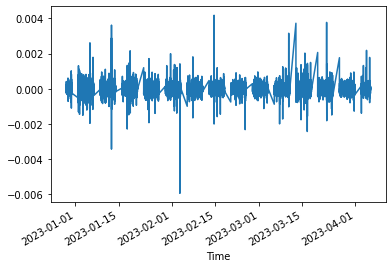

In [16]:
df_base_retornos.plot()

#### Volatilidade

In [17]:
#Volatilidade: Desvio padrão dos retornos
df_base_retornos.std()

0.00015435327821369823

#### Media Movel da Volatilidade em determinado periodo

<AxesSubplot:xlabel='Time'>

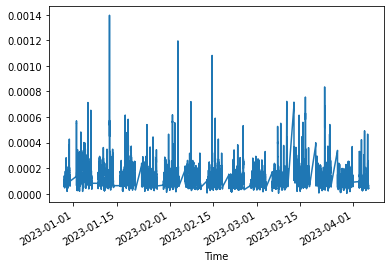

In [18]:
#Anual 252 em um gráfico diario
#Mensal 30 em um gráfico diario
media_movel_vol = df_base_retornos.rolling(window=30).std()
media_movel_vol.plot()

<AxesSubplot:xlabel='Time'>

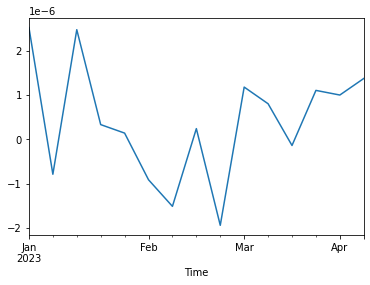

In [24]:
# Apresentando a função RESAMPLE que é similar a rolling do pandas e serve para agrupar os dados por periodos de tempo
df_base_retornos_semanal = df_base_retornos.resample('W').mean()
#df_base_retornos_semanal = df_base_retornos.resample('D').mean()
df_base_retornos_semanal.plot()

<AxesSubplot:xlabel='Time'>

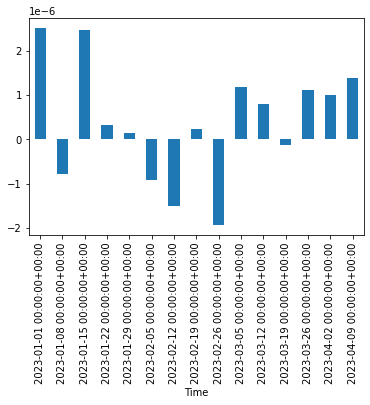

In [25]:
 df_base_retornos_semanal.plot.bar()

In [ ]:
# histograma e outras métricas estatisticas

<AxesSubplot:ylabel='Frequency'>

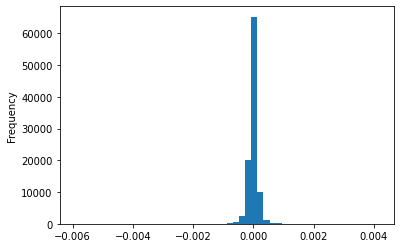

In [27]:
df_base_retornos.plot.hist(bins=50)

In [28]:
df_base_retornos.describe()

count    9.999800e+04
mean     2.680964e-07
std      1.543533e-04
min     -5.932110e-03
25%     -6.434119e-05
50%      0.000000e+00
75%      6.440557e-05
max      4.175501e-03
Name: Adj Close, dtype: float64